<a href="https://colab.research.google.com/github/SarbajitPbappy/ResearchWork/blob/main/LymeDiseaseAllModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing

In [ ]:
import cv2
import numpy as np
import os

# Function to apply gamma correction per channel
def adjust_gamma_channelwise(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")

    # Split the image into its component channels
    channels = cv2.split(image)

    # Apply the gamma correction on each channel
    channels_corrected = [cv2.LUT(ch, table) for ch in channels]

    # Merge the channels back together
    return cv2.merge(channels_corrected)

# Function to perform contrast stretching per channel
def contrast_stretching_channelwise(image):
    channels = cv2.split(image)
    channels_stretched = []

    for ch in channels:
        in_min = np.min(ch)
        in_max = np.max(ch)

        # Stretch the histogram to the full range
        stretched = cv2.normalize(ch, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        channels_stretched.append(stretched)

    # Merge the channels back together
    return cv2.merge(channels_stretched)

# Paths to the input and output folders
input_folder = '/content/drive/MyDrive/Selected/Selected Positive'
output_folder = '/content/drive/MyDrive/Research Paper/Lyme Disease/preprocess'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process all images in the input folder
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.jpg')):
        file_path = os.path.join(input_folder, filename)
        image = cv2.imread(file_path)

        # Apply gamma correction with gamma=0.85
        gamma_corrected = adjust_gamma_channelwise(image, gamma=0.85)

        # Apply contrast stretching
        contrast_stretched = contrast_stretching_channelwise(gamma_corrected)

        # Save the processed image to the output folder
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, contrast_stretched)

print(f"Processed images have been saved to {output_folder}")


Processed images have been saved to /content/drive/MyDrive/Research Paper/Lyme Disease/preprocess


## AUgmentation

In [ ]:
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
import numpy as np
import os

def add_noise(image):
    np_image = np.array(image)
    noise = np.random.normal(0, 25, np_image.shape)
    np_image = np.clip(np_image + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(np_image)

def get_jpeg_filename(original_filename, prefix):
    return f"{prefix}_{original_filename.rsplit('.', 1)[0]}.jpg"

def augment_and_save_image(input_image, output_path, image_filename, rotation_angles, flip_horizontal, flip_vertical, brightness_factors, noise_addition, saturation_factors, contrast_factors, blur_factors, shear_factors):
    images_saved = 0
    base_filename = image_filename.rsplit('.', 1)[0]

    # Convert to JPEG and save the original image
    original_jpeg = input_image.convert('RGB')
    original_jpeg.save(os.path.join(output_path, f'{base_filename}.jpg'), 'JPEG')
    images_saved += 1

    # Apply augmentations
    for angle in rotation_angles:
        rotated_image = input_image.rotate(angle, expand=True).convert('RGB')
        rotated_image.save(os.path.join(output_path, get_jpeg_filename(image_filename, f'rotated_{angle}')), 'JPEG')
        images_saved += 1

    if flip_horizontal:
        h_flipped_image = ImageOps.mirror(input_image).convert('RGB')
        h_flipped_image.save(os.path.join(output_path, get_jpeg_filename(image_filename, 'hflip')), 'JPEG')
        images_saved += 1

    if flip_vertical:
        v_flipped_image = ImageOps.flip(input_image).convert('RGB')
        v_flipped_image.save(os.path.join(output_path, get_jpeg_filename(image_filename, 'vflip')), 'JPEG')
        images_saved += 1

    for factor in brightness_factors:
        enhancer = ImageEnhance.Brightness(input_image)
        brightness_image = enhancer.enhance(factor).convert('RGB')
        brightness_image.save(os.path.join(output_path, get_jpeg_filename(image_filename, f'brightness_{factor}')), 'JPEG')
        images_saved += 1

    if noise_addition:
        noisy_image = add_noise(input_image).convert('RGB')
        noisy_image.save(os.path.join(output_path, get_jpeg_filename(image_filename, 'noise')), 'JPEG')
        images_saved += 1

    for saturation_factor in saturation_factors:
        enhancer = ImageEnhance.Color(input_image)
        saturated_image = enhancer.enhance(saturation_factor).convert('RGB')
        saturated_image.save(os.path.join(output_path, get_jpeg_filename(image_filename, f'saturation_{saturation_factor}')), 'JPEG')
        images_saved += 1

    for contrast_factor in contrast_factors:
        enhancer = ImageEnhance.Contrast(input_image)
        contrasted_image = enhancer.enhance(contrast_factor).convert('RGB')
        contrasted_image.save(os.path.join(output_path, get_jpeg_filename(image_filename, f'contrast_{contrast_factor}')), 'JPEG')
        images_saved += 1

    for blur_factor in blur_factors:
        blurred_image = input_image.filter(ImageFilter.GaussianBlur(blur_factor)).convert('RGB')
        blurred_image.save(os.path.join(output_path, get_jpeg_filename(image_filename, f'blur_{blur_factor}')), 'JPEG')
        images_saved += 1

    for shear_factor in shear_factors:
        shear_matrix = [1, shear_factor, 0, 0, 1, 0]
        sheared_image = input_image.transform(input_image.size, Image.AFFINE, shear_matrix).convert('RGB')
        sheared_image.save(os.path.join(output_path, get_jpeg_filename(image_filename, f'shear_{shear_factor}')), 'JPEG')
        images_saved += 1

    return images_saved

def augment_images_in_folder(input_path, output_path, rotation_angles, flip_horizontal, flip_vertical, brightness_factors, noise_addition, saturation_factors, contrast_factors, blur_factors, shear_factors):
    total_images_saved = 0
    os.makedirs(output_path, exist_ok=True)

    for image_filename in os.listdir(input_path):
        if image_filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            try:
                input_image_path = os.path.join(input_path, image_filename)
                input_image = Image.open(input_image_path)
                images_saved = augment_and_save_image(input_image, output_path, image_filename, rotation_angles, flip_horizontal, flip_vertical, brightness_factors, noise_addition, saturation_factors, contrast_factors, blur_factors, shear_factors)
                total_images_saved += images_saved
                if total_images_saved >= 4000:
                    break
            except FileNotFoundError:
                print(f"File not found: {image_filename}")
            except Exception as e:
                print(f"An error occurred with {image_filename}: {e}")



# Specify the input and output directory paths
input_path = '/content/drive/MyDrive/Research Paper/Lyme Disease/preprocess'
output_path = '/content/drive/MyDrive/Research Paper/Lyme Disease/Final_data/positive'

# Call the function to augment all images in the input directory
augment_images_in_folder(
    input_path=input_path,
    output_path=output_path,
    rotation_angles=[30, 45, 90, 180, 270, 360],
    flip_horizontal=True,
    flip_vertical=True,
    brightness_factors=[0.5, 0.7, 1.3],
    noise_addition=True,
    saturation_factors=[0.5, 1.5],
    contrast_factors=[0.5, 1.5],
    blur_factors=[1, 2, 3],
    shear_factors=[0.2, 0.5]
)


In [ ]:
import shutil

# Specify the folder path to be deleted
folder_path = '/content/drive/MyDrive/Research Paper/Lyme Disease/Final_data/positive'

try:
    # Use shutil.rmtree to remove the folder and its contents recursively
    shutil.rmtree(folder_path)
    print(f"Deleted folder and its contents: {folder_path}")
except Exception as e:
    print(f"Error deleting folder: {e}")


Deleted folder and its contents: /content/drive/MyDrive/Research Paper/Lyme Disease/Final_data/positive


In [ ]:
import os

# Specify the folder path
folder_path = '/content/drive/MyDrive/Research Paper/Lyme Disease/Final_data/negative'

# Initialize a set to store unique file extensions
extensions = set()

# List all files in the folder
for file_name in os.listdir(folder_path):
    # Split the file name into its base name and extension
    base_name, file_extension = os.path.splitext(file_name)
    # Add the extension (without the dot) to the set
    extensions.add(file_extension.lower())

# Print the unique image file extensions
print("Image file extensions in the folder:")
for ext in extensions:
    print(ext)


Image file extensions in the folder:
.jpg


## **Import all Library**

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import datasets, layers, models

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from time import perf_counter
import seaborn as sns
import glob
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn import metrics

import seaborn as sns
def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

## Adding File Path

In [ ]:
image_dir = Path('/content/drive/MyDrive/Research Paper/Lyme Disease/Final_data')
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
# Count the number of files in the directory
total_files = sum(1 for _ in image_dir.glob('**/*.jpg'))

total_files

8122

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,/content/drive/MyDrive/Research Paper/Lyme Dis...,positive
1,/content/drive/MyDrive/Research Paper/Lyme Dis...,positive
2,/content/drive/MyDrive/Research Paper/Lyme Dis...,positive


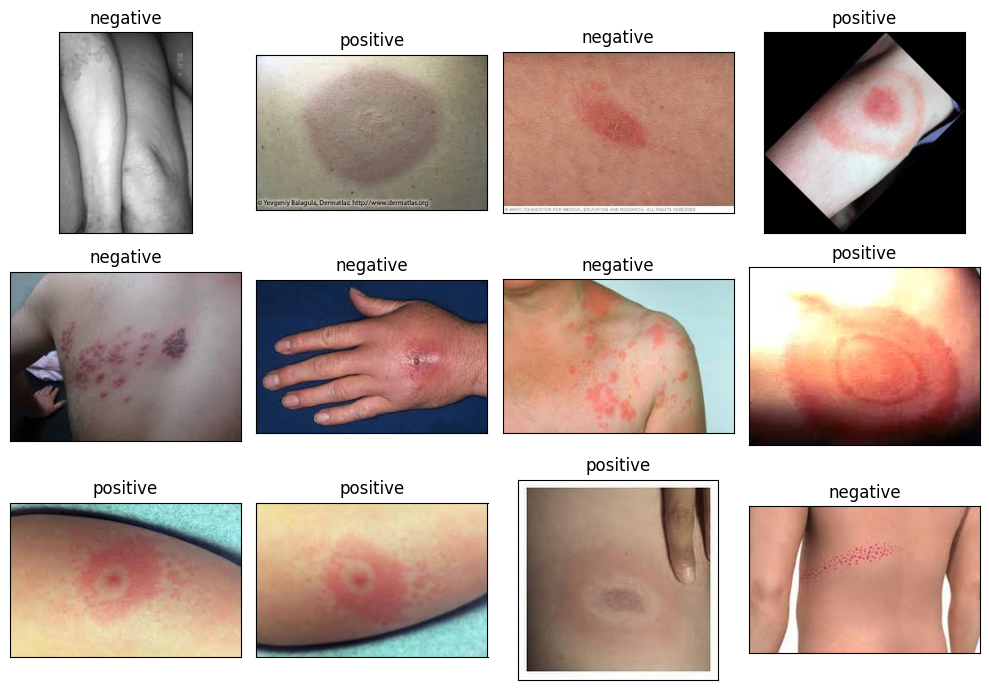

In [ ]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [ ]:
vc = image_df['Label'].value_counts()
print(vc)

negative    4118
positive    4004
Name: Label, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set the grid style
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.5

# Assume 'image_df' has a column 'Label' with categories 'Negative' and 'Positive'
# Calculate value counts for each label
vc = image_df['Label'].value_counts()  # Ensure image_df is defined

# Define your custom palette
custom_palette = ['#408baf', '#ff6b6b', '#36454f', '#ffd700']

# Set the figure size
plt.figure(figsize=(14, 7))

# Create a barplot with the custom palette
sns.barplot(x=vc.index, y=vc, palette=custom_palette)

# Set the title and labels
plt.title('Number of Pictures of Each Category', fontsize=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Pictures', fontsize=12)

# Define the directory to save the figure
output_directory = '/content/drive/MyDrive/Research Paper/Lyme Disease/AllOutput'  # Replace with your actual directory path
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save the figure
plt.savefig(os.path.join(output_directory, 'image_category_plot.png'), bbox_inches='tight')

# Show the plot
plt.show()


## Data Split

In [ ]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

In [ ]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()

Found 6497 validated image filenames belonging to 2 classes.
Found 6497 validated image filenames belonging to 2 classes.
Found 1625 validated image filenames belonging to 2 classes.


In [ ]:
# Count in training data before split
train_counts = train_df['Label'].value_counts()

# Since we don't directly split the validation data,
# we infer its counts based on the validation_split and training data counts

# Count in test data
test_counts = test_df['Label'].value_counts()

print("Training dataset (before validation split) distribution:\n", train_counts)
print("\nTest dataset distribution:\n", test_counts)

# Note: This does not directly show the validation counts because they're a subset of train_df,
# but you can calculate it based on the `validation_split` percentage.


Training dataset (before validation split) distribution:
 negative    3275
positive    3222
Name: Label, dtype: int64

Test dataset distribution:
 negative    843
positive    782
Name: Label, dtype: int64


In [ ]:
# Assuming train_df has already been split and train_counts calculated as shown previously
validation_split_ratio = 0.1  # 10% of the data is for validation

# Calculate the expected number of samples for each class in the validation set
validation_counts = train_counts * validation_split_ratio

# Since validation_counts will be a Series with the count of each class,
# rounding might be necessary because actual counts of samples can't be fractional.
validation_counts_rounded = validation_counts.round().astype(int)

print("Expected validation dataset distribution (rounded):\n", validation_counts_rounded)


Expected validation dataset distribution (rounded):
 negative    328
positive    322
Name: Label, dtype: int64


In [ ]:
# Adjust the training dataset counts to exclude the validation set
adjusted_train_counts = train_counts - validation_counts_rounded

print("Adjusted training dataset distribution (after validation split):\n", adjusted_train_counts)

Adjusted training dataset distribution (after validation split):
 negative    2947
positive    2900
Name: Label, dtype: int64


## **Transfer Learning Model**

In [ ]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(256, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
# def get_model(model):
#     # Load the pretrained model with specified kwargs
#     kwargs = {
#         'input_shape': (224, 224, 3),
#         'include_top': False,
#         'weights': 'imagenet',
#         'pooling': 'avg'
#     }

#     pretrained_model = model(**kwargs)
#     pretrained_model.trainable = False  # Freeze the pretrained model

#     inputs = pretrained_model.input

#     # Use a simpler architecture with potentially less capacity to learn complex patterns
#     x = tf.keras.layers.Dense(64, activation='linear')(pretrained_model.output)  # Reduced number of neurons and linear activation

#     outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

#     model = tf.keras.Model(inputs=inputs, outputs=outputs)

#     model.compile(
#         optimizer='adam',  # Potentially inappropriate learning rate
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

##Model Fit



VGG19 Model : 
Epoch 1/20
204/204 [==============================] - 67s 324ms/step - loss: 0.4705 - accuracy: 0.7619 - val_loss: 0.3596 - val_accuracy: 0.8296
Epoch 2/20
204/204 [==============================] - 68s 335ms/step - loss: 0.3424 - accuracy: 0.8424 - val_loss: 0.3217 - val_accuracy: 0.8558
Epoch 3/20
204/204 [==============================] - 68s 334ms/step - loss: 0.2976 - accuracy: 0.8732 - val_loss: 0.2537 - val_accuracy: 0.8938
Epoch 4/20
204/204 [==============================] - 75s 368ms/step - loss: 0.2555 - accuracy: 0.8933 - val_loss: 0.2567 - val_accuracy: 0.8947
Epoch 5/20
204/204 [==============================] - 76s 374ms/step - loss: 0.2365 - accuracy: 0.8989 - val_loss: 0.2355 - val_accuracy: 0.8986
Epoch 6/20
204/204 [==============================] - 69s 337ms/step - loss: 0.2158 - accuracy: 0.9100 - val_loss: 0.1811 - val_accuracy: 0.9317
Epoch 7/20
204/204 [==============================] - 69s 336ms/step - loss: 0.2480 - accuracy: 0.8973 - val_loss

<Figure size 640x480 with 0 Axes>

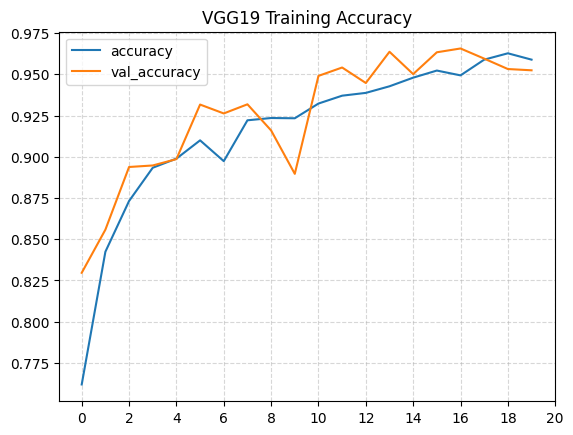

<Figure size 640x480 with 0 Axes>

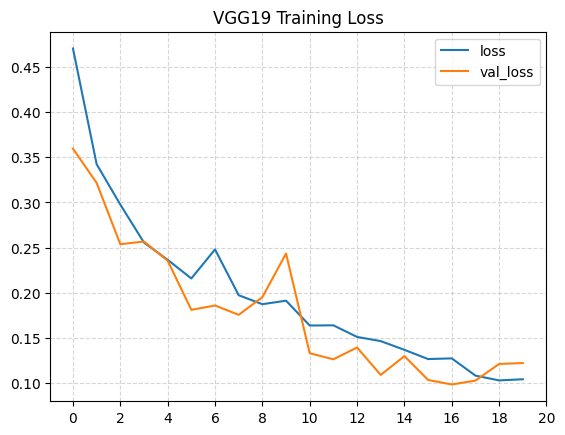


Accuracy on the test set for VGG19: 92.31%
51/51 [==============================] - 9s 180ms/step
Accuracy: 0.92308
Precision: 0.92522
Recall: 0.92308
F1 Score: 0.92301
              precision    recall  f1-score   support

    negative       0.96      0.89      0.92       821
    positive       0.89      0.96      0.92       804

    accuracy                           0.92      1625
   macro avg       0.92      0.92      0.92      1625
weighted avg       0.93      0.92      0.92      1625

VGG19 Confusion Matrix: 




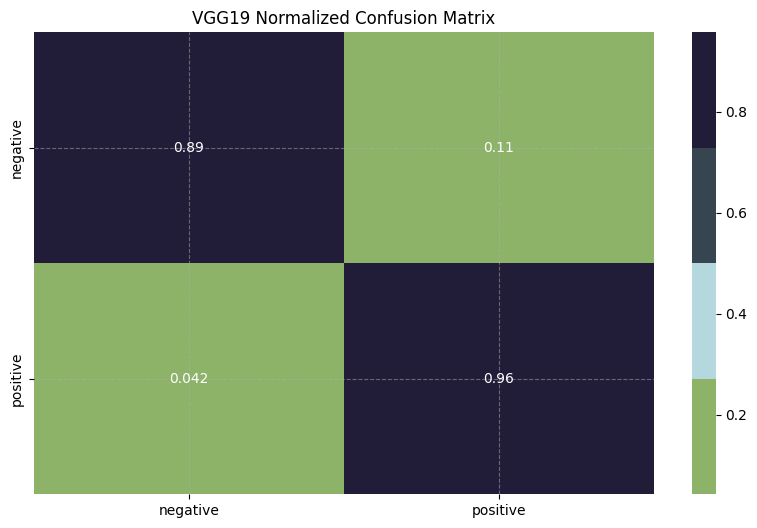

Performance for VGG19
Recall (Sensitivity): 92.34355021482115
Specificity: 99.99528543732438
Precision: 92.54347734867665
False Positive Rate: 0.004714562675602742
False Negative Rate: 7.656449785178854
Negative Predictive Value: 99.9952855264076
False Discovery Rate: 7.45652265132334


ResNet50V2 Model : 
Epoch 1/20
204/204 [==============================] - 91s 345ms/step - loss: 0.2626 - accuracy: 0.8904 - val_loss: 0.1012 - val_accuracy: 0.9648
Epoch 2/20
204/204 [==============================] - 74s 364ms/step - loss: 0.1076 - accuracy: 0.9615 - val_loss: 0.0597 - val_accuracy: 0.9818
Epoch 3/20
204/204 [==============================] - 62s 304ms/step - loss: 0.0573 - accuracy: 0.9812 - val_loss: 0.0364 - val_accuracy: 0.9874
Epoch 4/20
204/204 [==============================] - 62s 307ms/step - loss: 0.0309 - accuracy: 0.9888 - val_loss: 0.0265 - val_accuracy: 0.9911
Epoch 5/20
204/204 [==============================] - 62s 303ms/step - loss: 0.0284 - accuracy: 0.9923 - val_los

<Figure size 640x480 with 0 Axes>

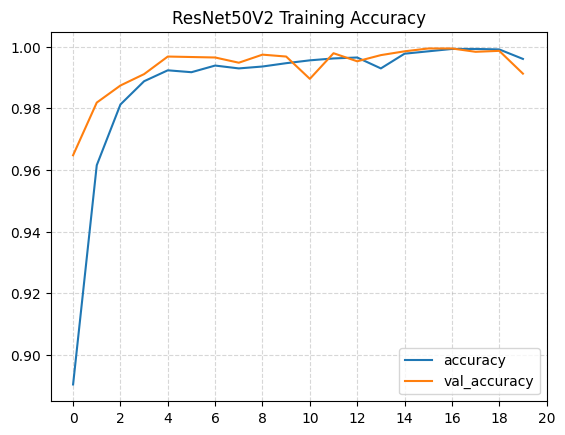

<Figure size 640x480 with 0 Axes>

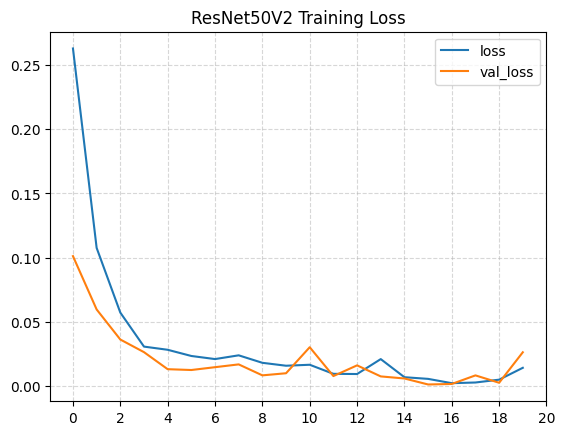


Accuracy on the test set for ResNet50V2: 95.14%
51/51 [==============================] - 8s 145ms/step
Accuracy: 0.95138
Precision: 0.95139
Recall: 0.95138
F1 Score: 0.95139
              precision    recall  f1-score   support

    negative       0.95      0.95      0.95       821
    positive       0.95      0.95      0.95       804

    accuracy                           0.95      1625
   macro avg       0.95      0.95      0.95      1625
weighted avg       0.95      0.95      0.95      1625

ResNet50V2 Confusion Matrix: 




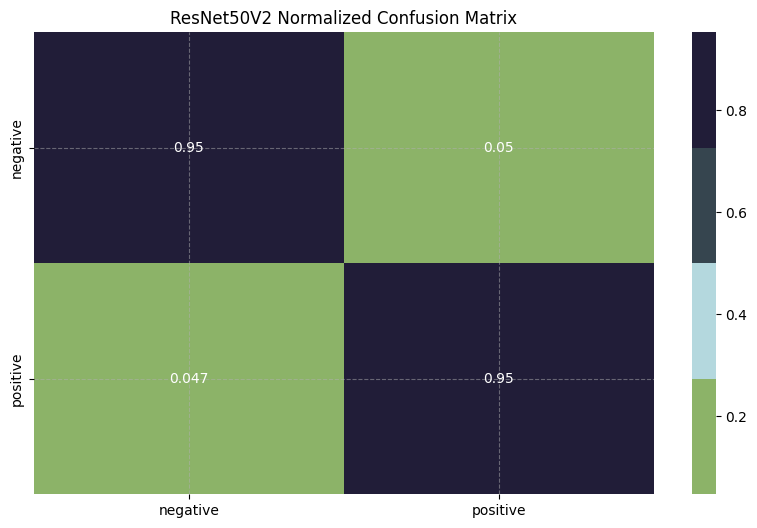

Performance for ResNet50V2
Recall (Sensitivity): 95.1398609873895
Specificity: 99.99700730356366
Precision: 95.1401840943491
False Positive Rate: 0.0029926964363365207
False Negative Rate: 4.860139012610515
Negative Predictive Value: 99.99700730369936
False Discovery Rate: 4.8598159056509


DenseNet201 Model : 
Epoch 1/20
204/204 [==============================] - 90s 388ms/step - loss: 0.2518 - accuracy: 0.8972 - val_loss: 0.1110 - val_accuracy: 0.9632
Epoch 2/20
204/204 [==============================] - 66s 325ms/step - loss: 0.1282 - accuracy: 0.9518 - val_loss: 0.0678 - val_accuracy: 0.9805
Epoch 3/20
204/204 [==============================] - 67s 328ms/step - loss: 0.0643 - accuracy: 0.9801 - val_loss: 0.0310 - val_accuracy: 0.9917
Epoch 4/20
204/204 [==============================] - 67s 330ms/step - loss: 0.0527 - accuracy: 0.9811 - val_loss: 0.0873 - val_accuracy: 0.9632
Epoch 5/20
204/204 [==============================] - 68s 334ms/step - loss: 0.0399 - accuracy: 0.9872 - va

<Figure size 640x480 with 0 Axes>

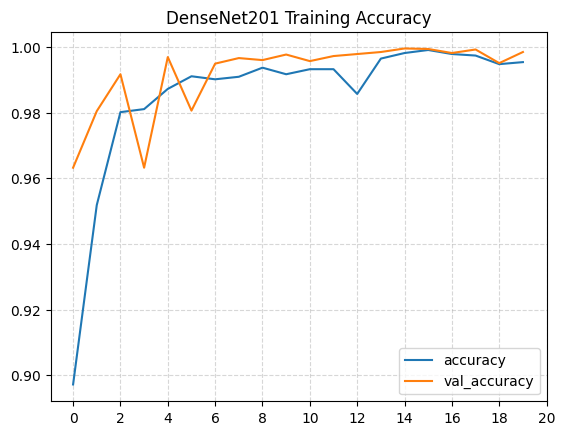

<Figure size 640x480 with 0 Axes>

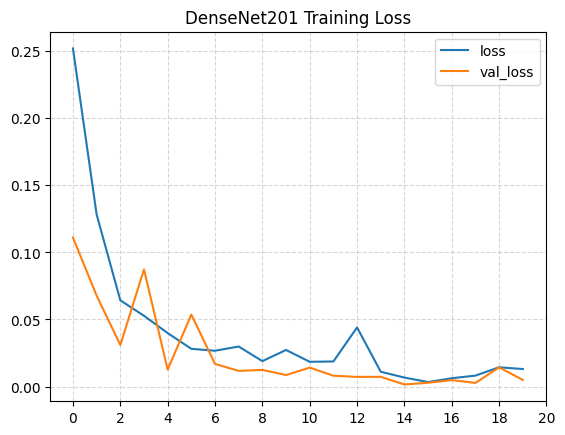


Accuracy on the test set for DenseNet201: 98.22%
51/51 [==============================] - 12s 171ms/step
Accuracy: 0.98215
Precision: 0.98228
Recall: 0.98215
F1 Score: 0.98215
              precision    recall  f1-score   support

    negative       0.99      0.97      0.98       821
    positive       0.97      0.99      0.98       804

    accuracy                           0.98      1625
   macro avg       0.98      0.98      0.98      1625
weighted avg       0.98      0.98      0.98      1625

DenseNet201 Confusion Matrix: 




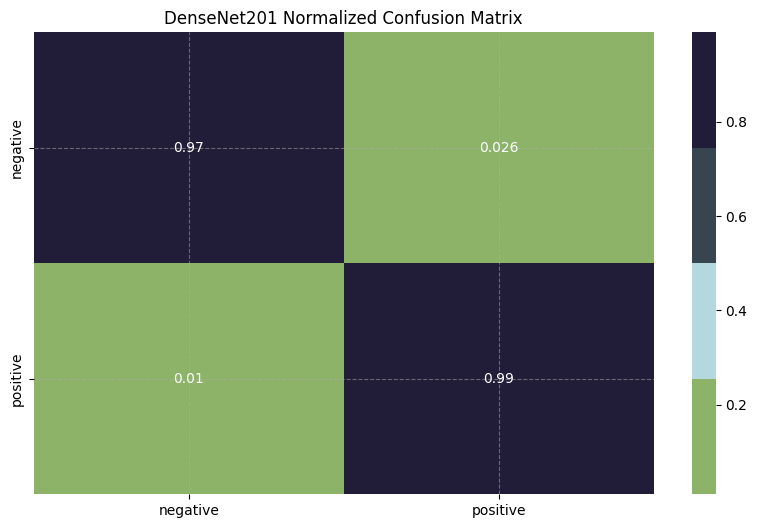

Performance for DenseNet201
Recall (Sensitivity): 98.22355942577006
Specificity: 99.99890613265133
Precision: 98.23534062783827
False Positive Rate: 0.0010938673486637577
False Negative Rate: 1.7764405742299427
Negative Predictive Value: 99.99890613728168
False Discovery Rate: 1.7646593721617334




In [ ]:
# Dictionary with the models
models = {
    "VGG19": {"model": tf.keras.applications.VGG19, "perf": 0},
    "ResNet50V2": {"model": tf.keras.applications.ResNet50V2, "perf": 0},
    "DenseNet201": {"model": tf.keras.applications.DenseNet201, "perf": 0},
}
# Custom color palette
custom_palette = ['#8CB368', '#B4D8DE', '#36454f', '#211d38']
# Create the generators
# train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')
output_dir = "/content/drive/MyDrive/Research Paper/Lyme Disease/AfterTuning"
os.makedirs(output_dir, exist_ok=True)
# Fit the models
for name, model in models.items():
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m

    print(f"{name} Model : ")

    start = perf_counter()

    # Fit the model
    # Assuming train_images and val_images are generators or datasets ready for training.
    history = m.fit(train_images, validation_data=val_images, epochs=20, verbose=1)

    # Save the duration, the train_accuracy, and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration, 2)
    models[name]['perf'] = duration
    print(f"{name} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v, 4) for v in val_acc]

    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v, 4) for v in train_acc]

    # Evaluate the model
    results = m.evaluate(test_images, verbose=0)
    res = results[1]
    models[name]['test_accuracy'] = [round(res, 4)]

    # Plotting training accuracy and loss
    plt.figure()
    pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
    plt.title(f"{name} Training Accuracy")
    plt.xticks(range(0, 21, 2))  # Setting x-axis ticks
    accuracy_plot = os.path.join(output_dir, f"{name}_accuracy_plot.png")
    plt.savefig(accuracy_plot)
    plt.show()

    plt.figure()
    pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
    plt.title(f"{name} Training Loss")
    plt.xticks(range(0, 21, 2))  # Setting x-axis ticks
    loss_plot = os.path.join(output_dir, f"{name}_loss_plot.png")
    plt.savefig(loss_plot)
    plt.show()

    print(f"\nAccuracy on the test set for {name}: {results[1] * 100:.2f}%")


    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # Evaluation and Confusion Matrix
    pred = m.predict(test_images)
    pred = np.argmax(pred, axis=1)

    # Mapping the label
    labels = (train_images.class_indices)
    labels = dict((v, k) for k, v in labels.items())
    pred = [labels[k] for k in pred]
    y_test = list(test_df.Label)  # Assuming test_df is defined

    print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
    print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
    print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
    print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
    print(classification_report(y_test, pred))


    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    import math
    from numpy import mean


    print(f"{name:2} Confusion Matrix: \n\n")
    cf_matrix = confusion_matrix(y_test, pred, normalize='true')
    plt.figure(figsize=(10, 6))
    sns.heatmap(cf_matrix, annot=True, cmap=sns.color_palette(custom_palette, as_cmap=True),
                xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
    plt.title(f'{name} Normalized Confusion Matrix')
    confusion_matrix_plot = os.path.join(output_dir, f"{name}_confusion_matrix.png")
    plt.savefig(confusion_matrix_plot)
    plt.show()
    confusion_matrix=cf_matrix

    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = len(y_test) - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Printing performance metrics
    print("Performance for", name)
    print("Recall (Sensitivity):", np.mean(TPR)*100)
    print("Specificity:", np.mean(TNR)*100)
    print("Precision:", np.mean(PPV)*100)
    print("False Positive Rate:", np.mean(FPR)*100)
    print("False Negative Rate:", np.mean(FNR)*100)
    print("Negative Predictive Value:", np.mean(NPV)*100)
    print("False Discovery Rate:", np.mean(FDR)*100)
    print("\n")


## DenseNet201



DenseNet201 Model : 
Epoch 1/20
204/204 [==============================] - 3536s 17s/step - loss: 0.3173 - accuracy: 0.8712 - val_loss: 0.1609 - val_accuracy: 0.9404
Epoch 2/20
204/204 [==============================] - 124s 612ms/step - loss: 0.1738 - accuracy: 0.9330 - val_loss: 0.1356 - val_accuracy: 0.9501
Epoch 3/20
204/204 [==============================] - 65s 321ms/step - loss: 0.1380 - accuracy: 0.9487 - val_loss: 0.1442 - val_accuracy: 0.9427
Epoch 4/20
204/204 [==============================] - 66s 324ms/step - loss: 0.1283 - accuracy: 0.9511 - val_loss: 0.0923 - val_accuracy: 0.9704
Epoch 5/20
204/204 [==============================] - 66s 323ms/step - loss: 0.1103 - accuracy: 0.9617 - val_loss: 0.1229 - val_accuracy: 0.9554
Epoch 6/20
204/204 [==============================] - 67s 330ms/step - loss: 0.1123 - accuracy: 0.9588 - val_loss: 0.1590 - val_accuracy: 0.9326
Epoch 7/20
204/204 [==============================] - 65s 320ms/step - loss: 0.1186 - accuracy: 0.9540 - v

<Figure size 640x480 with 0 Axes>

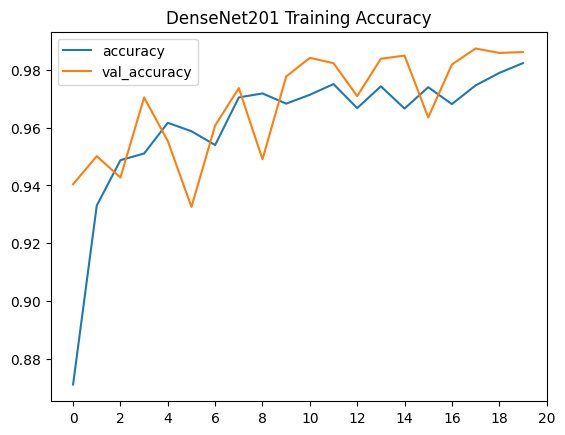

<Figure size 640x480 with 0 Axes>

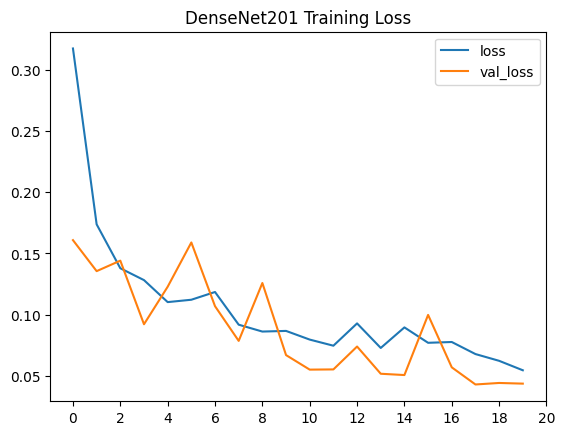


Accuracy on the test set for DenseNet201: 93.54%
51/51 [==============================] - 12s 153ms/step
Accuracy: 0.93538
Precision: 0.93538
Recall: 0.93538
F1 Score: 0.93538
              precision    recall  f1-score   support

    negative       0.94      0.94      0.94       856
    positive       0.93      0.93      0.93       769

    accuracy                           0.94      1625
   macro avg       0.94      0.94      0.94      1625
weighted avg       0.94      0.94      0.94      1625

DenseNet201 Confusion Matrix: 




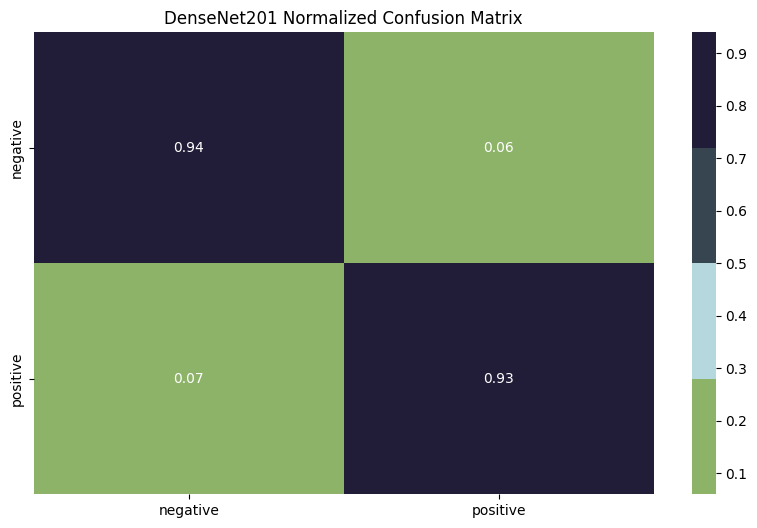

Performance for DenseNet201
Recall (Sensitivity): 93.50997472138837
Specificity: 99.99600367901564
Precision: 93.51490253287325
False Positive Rate: 0.003996320984366763
False Negative Rate: 6.490025278611622
Negative Predictive Value: 99.99600368116236
False Discovery Rate: 6.485097467126753




In [ ]:
# Dictionary with the models
models = {
    # "VGG19": {"model": tf.keras.applications.VGG19, "perf": 0},
    # "ResNet50V2": {"model": tf.keras.applications.ResNet50V2, "perf": 0},
    "DenseNet201": {"model": tf.keras.applications.DenseNet201, "perf": 0},
}
# Custom color palette
custom_palette = ['#8CB368', '#B4D8DE', '#36454f', '#211d38']
# Create the generators
# train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')
output_dir = "/content/drive/MyDrive/Research Paper/Lyme Disease/AfterTuning/DenseNet201"
os.makedirs(output_dir, exist_ok=True)
# Fit the models
for name, model in models.items():
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m

    print(f"{name} Model : ")

    start = perf_counter()

    # Fit the model
    # Assuming train_images and val_images are generators or datasets ready for training.
    history = m.fit(train_images, validation_data=val_images, epochs=20, verbose=1)

    # Save the duration, the train_accuracy, and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration, 2)
    models[name]['perf'] = duration
    print(f"{name} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v, 4) for v in val_acc]

    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v, 4) for v in train_acc]

    # Evaluate the model
    results = m.evaluate(test_images, verbose=0)
    res = results[1]
    models[name]['test_accuracy'] = [round(res, 4)]

    # Plotting training accuracy and loss
    plt.figure()
    pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
    plt.title(f"{name} Training Accuracy")
    plt.xticks(range(0, 21, 2))  # Setting x-axis ticks
    accuracy_plot = os.path.join(output_dir, f"{name}_accuracy_plot.png")
    plt.savefig(accuracy_plot)
    plt.show()

    plt.figure()
    pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
    plt.title(f"{name} Training Loss")
    plt.xticks(range(0, 21, 2))  # Setting x-axis ticks
    loss_plot = os.path.join(output_dir, f"{name}_loss_plot.png")
    plt.savefig(loss_plot)
    plt.show()

    print(f"\nAccuracy on the test set for {name}: {results[1] * 100:.2f}%")


    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # Evaluation and Confusion Matrix
    pred = m.predict(test_images)
    pred = np.argmax(pred, axis=1)

    # Mapping the label
    labels = (train_images.class_indices)
    labels = dict((v, k) for k, v in labels.items())
    pred = [labels[k] for k in pred]
    y_test = list(test_df.Label)  # Assuming test_df is defined

    print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
    print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
    print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
    print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
    print(classification_report(y_test, pred))


    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    import math
    from numpy import mean


    print(f"{name:2} Confusion Matrix: \n\n")
    cf_matrix = confusion_matrix(y_test, pred, normalize='true')
    plt.figure(figsize=(10, 6))
    sns.heatmap(cf_matrix, annot=True, cmap=sns.color_palette(custom_palette, as_cmap=True),
                xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
    plt.title(f'{name} Normalized Confusion Matrix')
    confusion_matrix_plot = os.path.join(output_dir, f"{name}_confusion_matrix.png")
    plt.savefig(confusion_matrix_plot)
    plt.show()
    confusion_matrix=cf_matrix

    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = len(y_test) - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Printing performance metrics
    print("Performance for", name)
    print("Recall (Sensitivity):", np.mean(TPR)*100)
    print("Specificity:", np.mean(TNR)*100)
    print("Precision:", np.mean(PPV)*100)
    print("False Positive Rate:", np.mean(FPR)*100)
    print("False Negative Rate:", np.mean(FNR)*100)
    print("Negative Predictive Value:", np.mean(NPV)*100)
    print("False Discovery Rate:", np.mean(FDR)*100)
    print("\n")


## Save Model


In [ ]:
for name, model_data in models.items():
    model = model_data['model']
    model.save(f'/content/drive/MyDrive/Research Paper/Lyme Disease/AllOutput/ModelD201/{name}')

## Roc Dense


==================== DenseNet201 ====================
Unique classes in y_test: ['negative' 'positive']
51/51 [==============================] - 9s 174ms/step


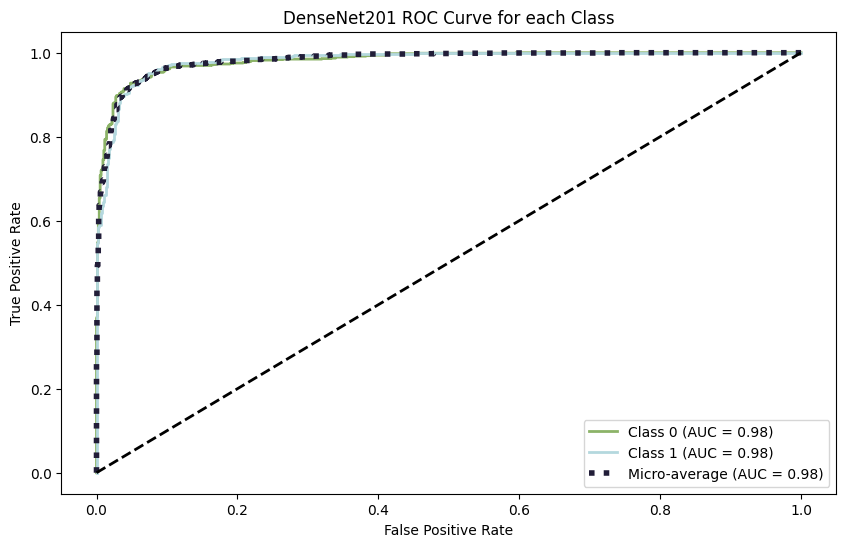

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import os

# Custom color palette
custom_palette = ['#8CB368', '#B4D8DE', '#36454f', '#211d38']

# Output directory
output_dir = "/content/drive/MyDrive/Research Paper/Lyme Disease/AllOutput/D2"
os.makedirs(output_dir, exist_ok=True)

# Fit the models
for name, model_info in models.items():
    # Get the model
    m = model_info['model']

    print(f"\n{ '=' * 20 } { name } {'=' * 20 }")

    # Check the unique classes in y_test
    unique_classes = np.unique(y_test)  # Assuming y_test is defined
    print("Unique classes in y_test:", unique_classes)

    # Ensure that there are 2 unique classes
    if len(unique_classes) != 2:
        raise ValueError("Expected 2 unique classes in y_test, got {}".format(len(unique_classes)))

    # Convert labels to binary matrix
    y_test_bin = label_binarize(y_test, classes=unique_classes)

    # Handling a special case for binary classification
    if y_test_bin.shape[1] == 1:
        y_test_bin = np.hstack((1 - y_test_bin, y_test_bin))

    # Predict probabilities for each class
    y_score = m.predict(test_images)  # Ensure test_images is defined

    # Ensure that y_score has two columns
    if y_score.shape[1] != 2:
        raise ValueError("y_score should have 2 columns for 2 classes, found {}".format(y_score.shape[1]))

    # Compute ROC curve and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curves
    plt.figure(figsize=(10, 6))
    colors = custom_palette[:2] + ['black']
    for i, color in zip(range(2), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot(fpr["micro"], tpr["micro"], color=custom_palette[3],
             label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve for each Class')
    plt.legend(loc='lower right')

    # Saving the plot
    roc_plot = os.path.join(output_dir, f"{name}_ROC_Curve.png")
    plt.savefig(roc_plot)
    plt.show()

    print(f"ROC curve saved for {name}")

##  ROC curve


==================== VGG19 ====================
Unique classes in y_test: ['negative' 'positive']
51/51 [==============================] - 9s 186ms/step


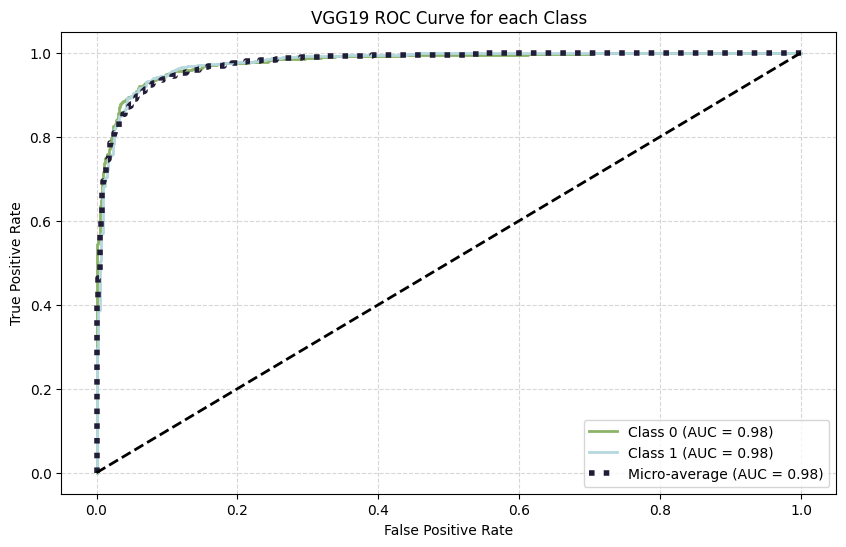

ROC curve saved for VGG19

==================== ResNet50V2 ====================
Unique classes in y_test: ['negative' 'positive']
51/51 [==============================] - 8s 159ms/step


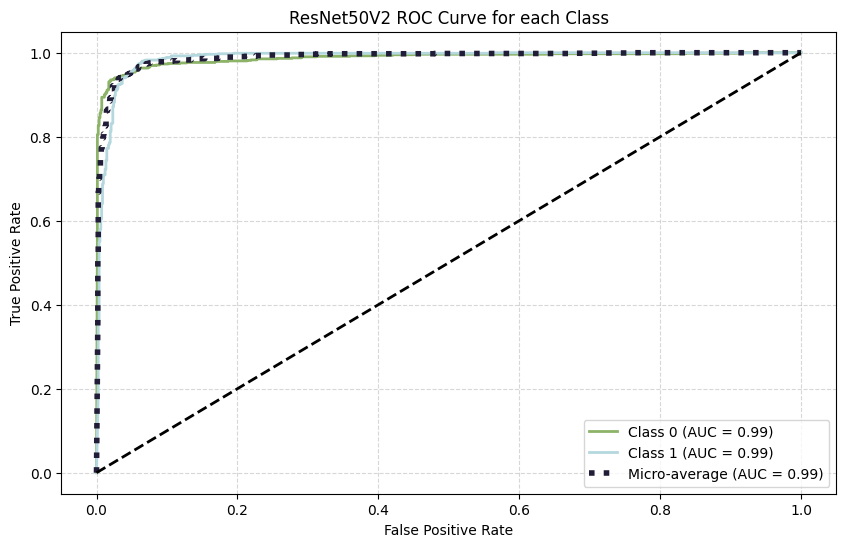

ROC curve saved for ResNet50V2

==================== DenseNet201 ====================
Unique classes in y_test: ['negative' 'positive']
51/51 [==============================] - 8s 155ms/step


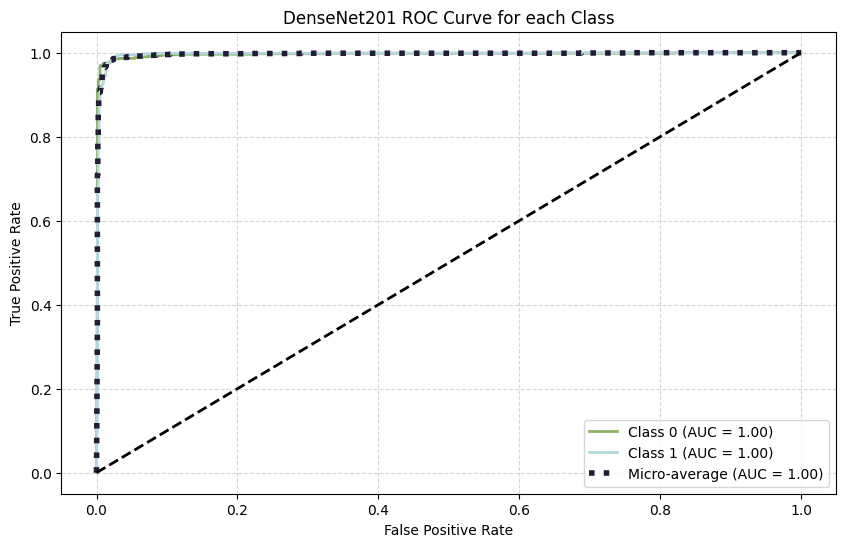

ROC curve saved for DenseNet201


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import os

# Custom color palette
custom_palette = ['#8CB368', '#B4D8DE', '#36454f', '#211d38']

# Output directory
output_dir = "/content/drive/MyDrive/Research Paper/Lyme Disease/AllOutput"
os.makedirs(output_dir, exist_ok=True)

# Fit the models
for name, model_info in models.items():
    # Get the model
    m = model_info['model']

    print(f"\n{ '=' * 20 } { name } {'=' * 20 }")

    # Check the unique classes in y_test
    unique_classes = np.unique(y_test)  # Assuming y_test is defined
    print("Unique classes in y_test:", unique_classes)

    # Ensure that there are 2 unique classes
    if len(unique_classes) != 2:
        raise ValueError("Expected 2 unique classes in y_test, got {}".format(len(unique_classes)))

    # Convert labels to binary matrix
    y_test_bin = label_binarize(y_test, classes=unique_classes)

    # Handling a special case for binary classification
    if y_test_bin.shape[1] == 1:
        y_test_bin = np.hstack((1 - y_test_bin, y_test_bin))

    # Predict probabilities for each class
    y_score = m.predict(test_images)  # Ensure test_images is defined

    # Ensure that y_score has two columns
    if y_score.shape[1] != 2:
        raise ValueError("y_score should have 2 columns for 2 classes, found {}".format(y_score.shape[1]))

    # Compute ROC curve and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curves
    plt.figure(figsize=(10, 6))
    colors = custom_palette[:2] + ['black']
    for i, color in zip(range(2), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot(fpr["micro"], tpr["micro"], color=custom_palette[3],
             label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve for each Class')
    plt.legend(loc='lower right')

    # Saving the plot
    roc_plot = os.path.join(output_dir, f"{name}_ROC_Curve.png")
    plt.savefig(roc_plot)
    plt.show()

    print(f"ROC curve saved for {name}")

## Miss Dense

ROC curve saved for DenseNet201

==================== DenseNet201 ====================
51/51 [==============================] - 8s 150ms/step
Misclassification Error: 0.0646

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       856
           1       0.93      0.93      0.93       769

    accuracy                           0.94      1625
   macro avg       0.94      0.94      0.94      1625
weighted avg       0.94      0.94      0.94      1625



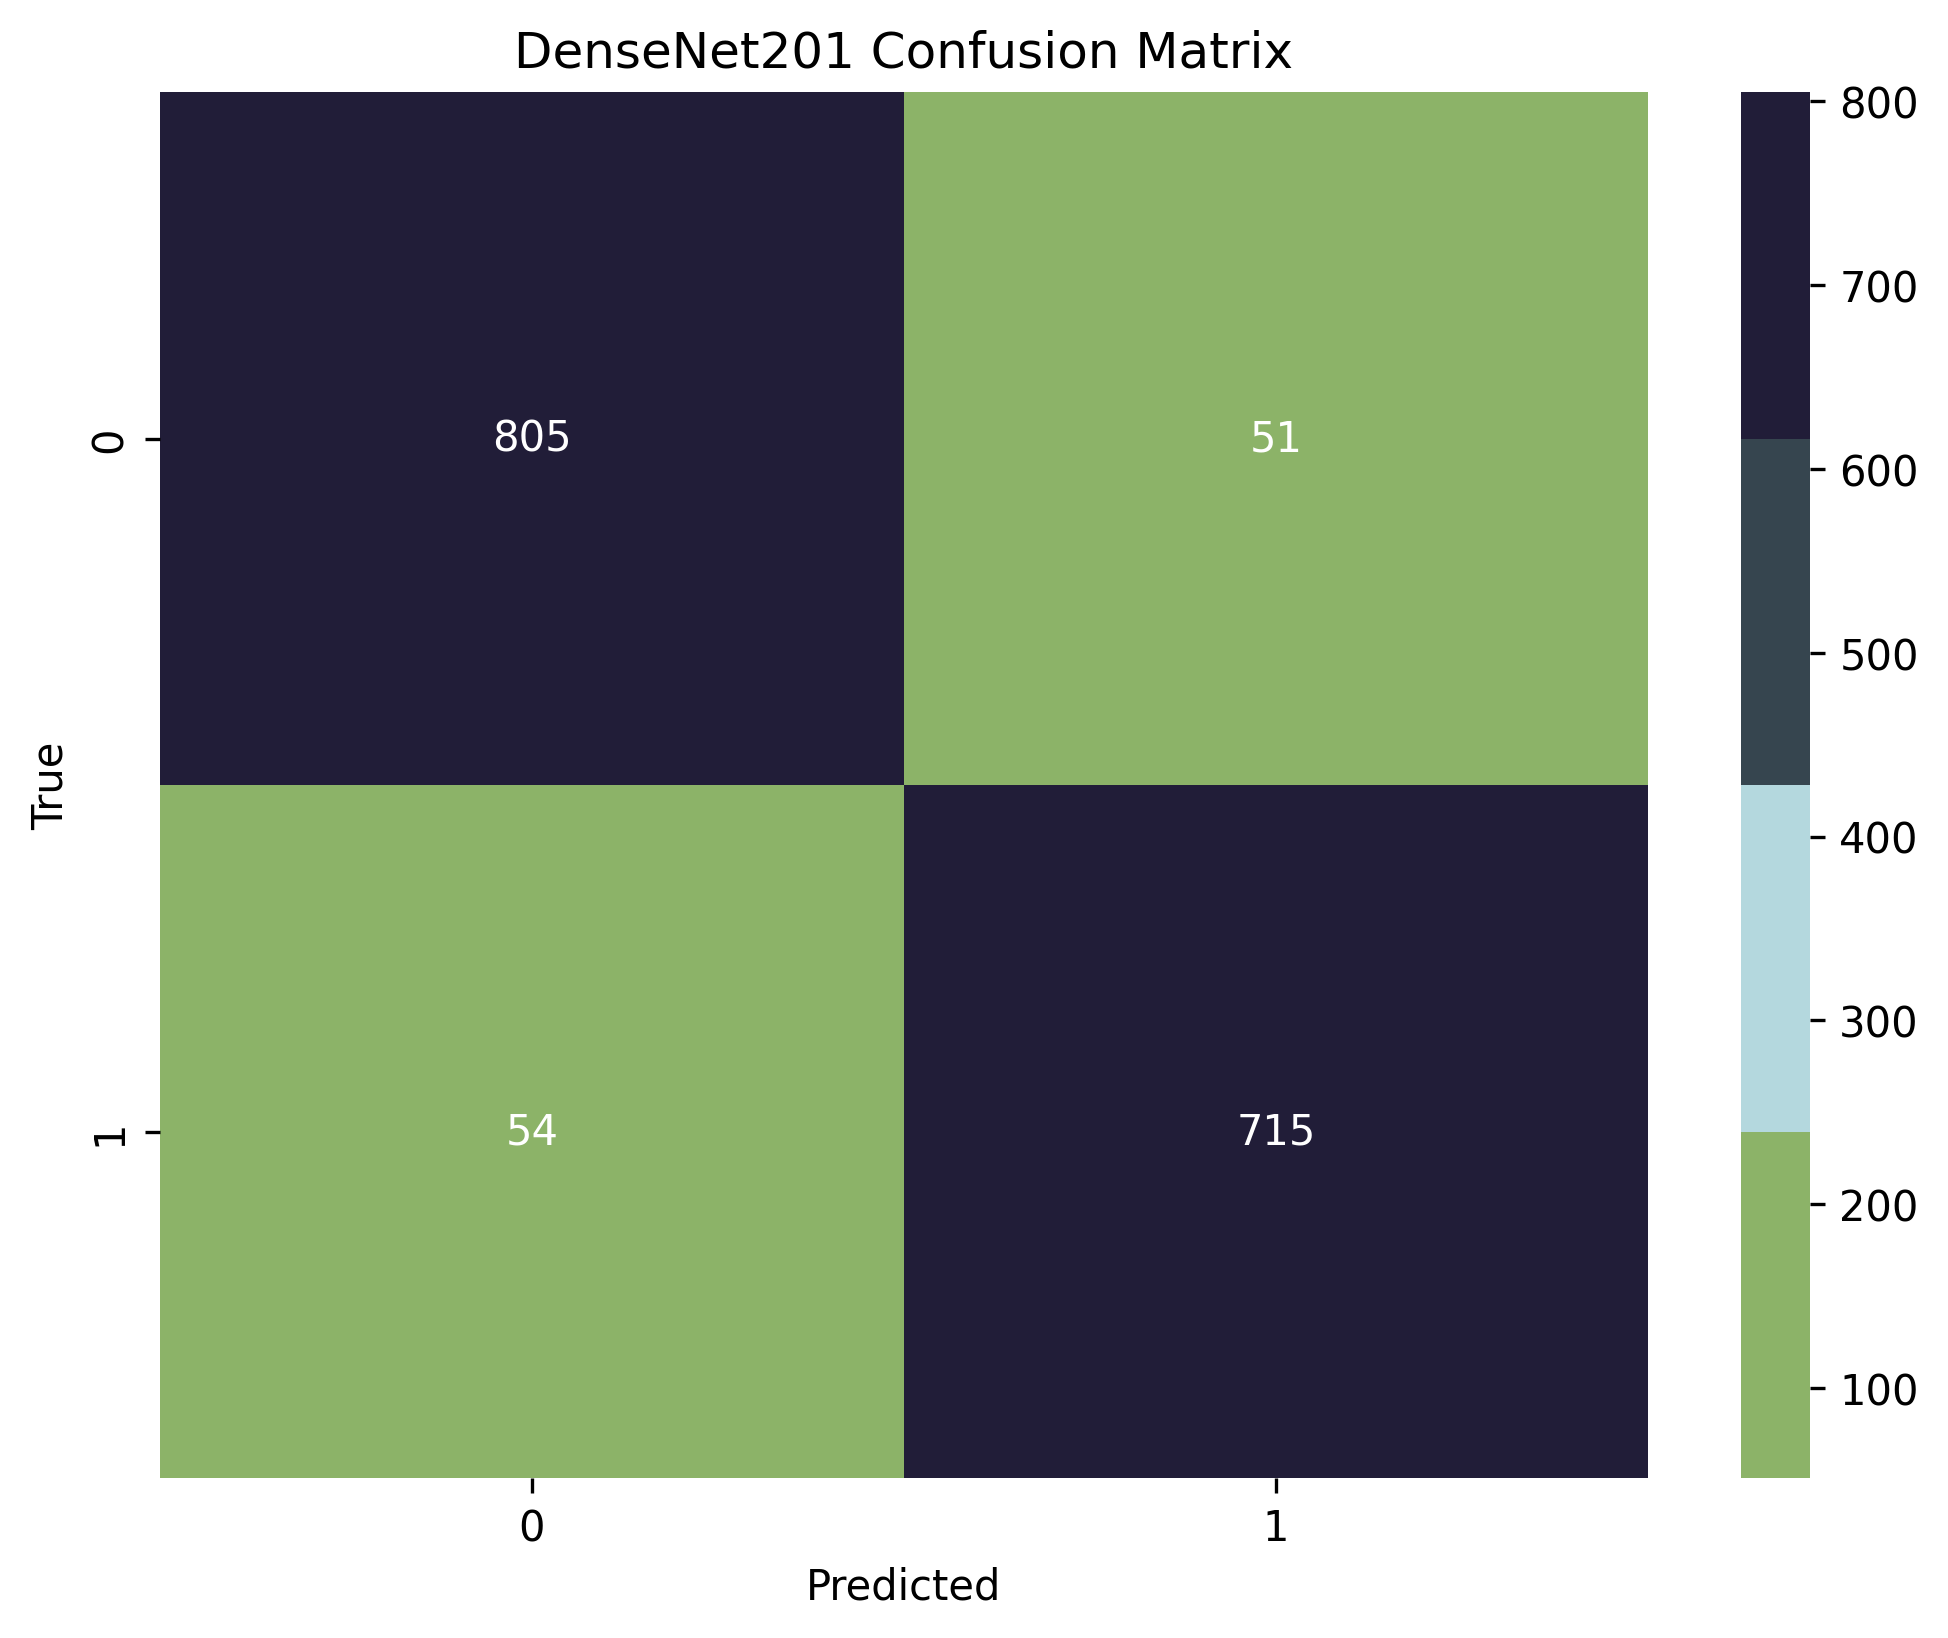

Confusion matrix saved for DenseNet201


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Custom color palette
custom_palette = ['#8CB368', '#B4D8DE', '#36454f', '#211d38']

# Output directory
output_dir = "/content/drive/MyDrive/Research Paper/Lyme Disease/AllOutput/D2"
os.makedirs(output_dir, exist_ok=True)

# Fit the models
for name, model_info in models.items():
    # Get the model
    m = model_info['model']

    print(f"\n{ '=' * 20 } { name } {'=' * 20 }")

    # Reset the state of the test_images generator
    test_images.reset()

    # Get predictions on the test set
    y_pred = m.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get true labels
    y_true = test_images.classes

    # Calculate misclassification error
    misclassification_error = 1 - accuracy_score(y_true, y_pred_classes)

    print(f'Misclassification Error: {misclassification_error:.4f}')

    # Display classification report
    print('\nClassification Report:\n', classification_report(y_true, y_pred_classes))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6), dpi=300)
    sns.heatmap(cm, annot=True, fmt='g', cmap=sns.color_palette(custom_palette, as_cmap=True),
                xticklabels=sorted(set(y_true)), yticklabels=sorted(set(y_true)))
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Saving the plot
    confusion_matrix_plot = os.path.join(output_dir, f"{name}_Confusion_Matrix.png")
    plt.savefig(confusion_matrix_plot, bbox_inches='tight')
    plt.show()

    print(f"Confusion matrix saved for {name}")

## Misclassification Error of the Transfer Leraning Models


==================== VGG19 ====================
51/51 [==============================] - 9s 168ms/step
Misclassification Error: 0.0769

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92       821
           1       0.89      0.96      0.92       804

    accuracy                           0.92      1625
   macro avg       0.92      0.92      0.92      1625
weighted avg       0.93      0.92      0.92      1625



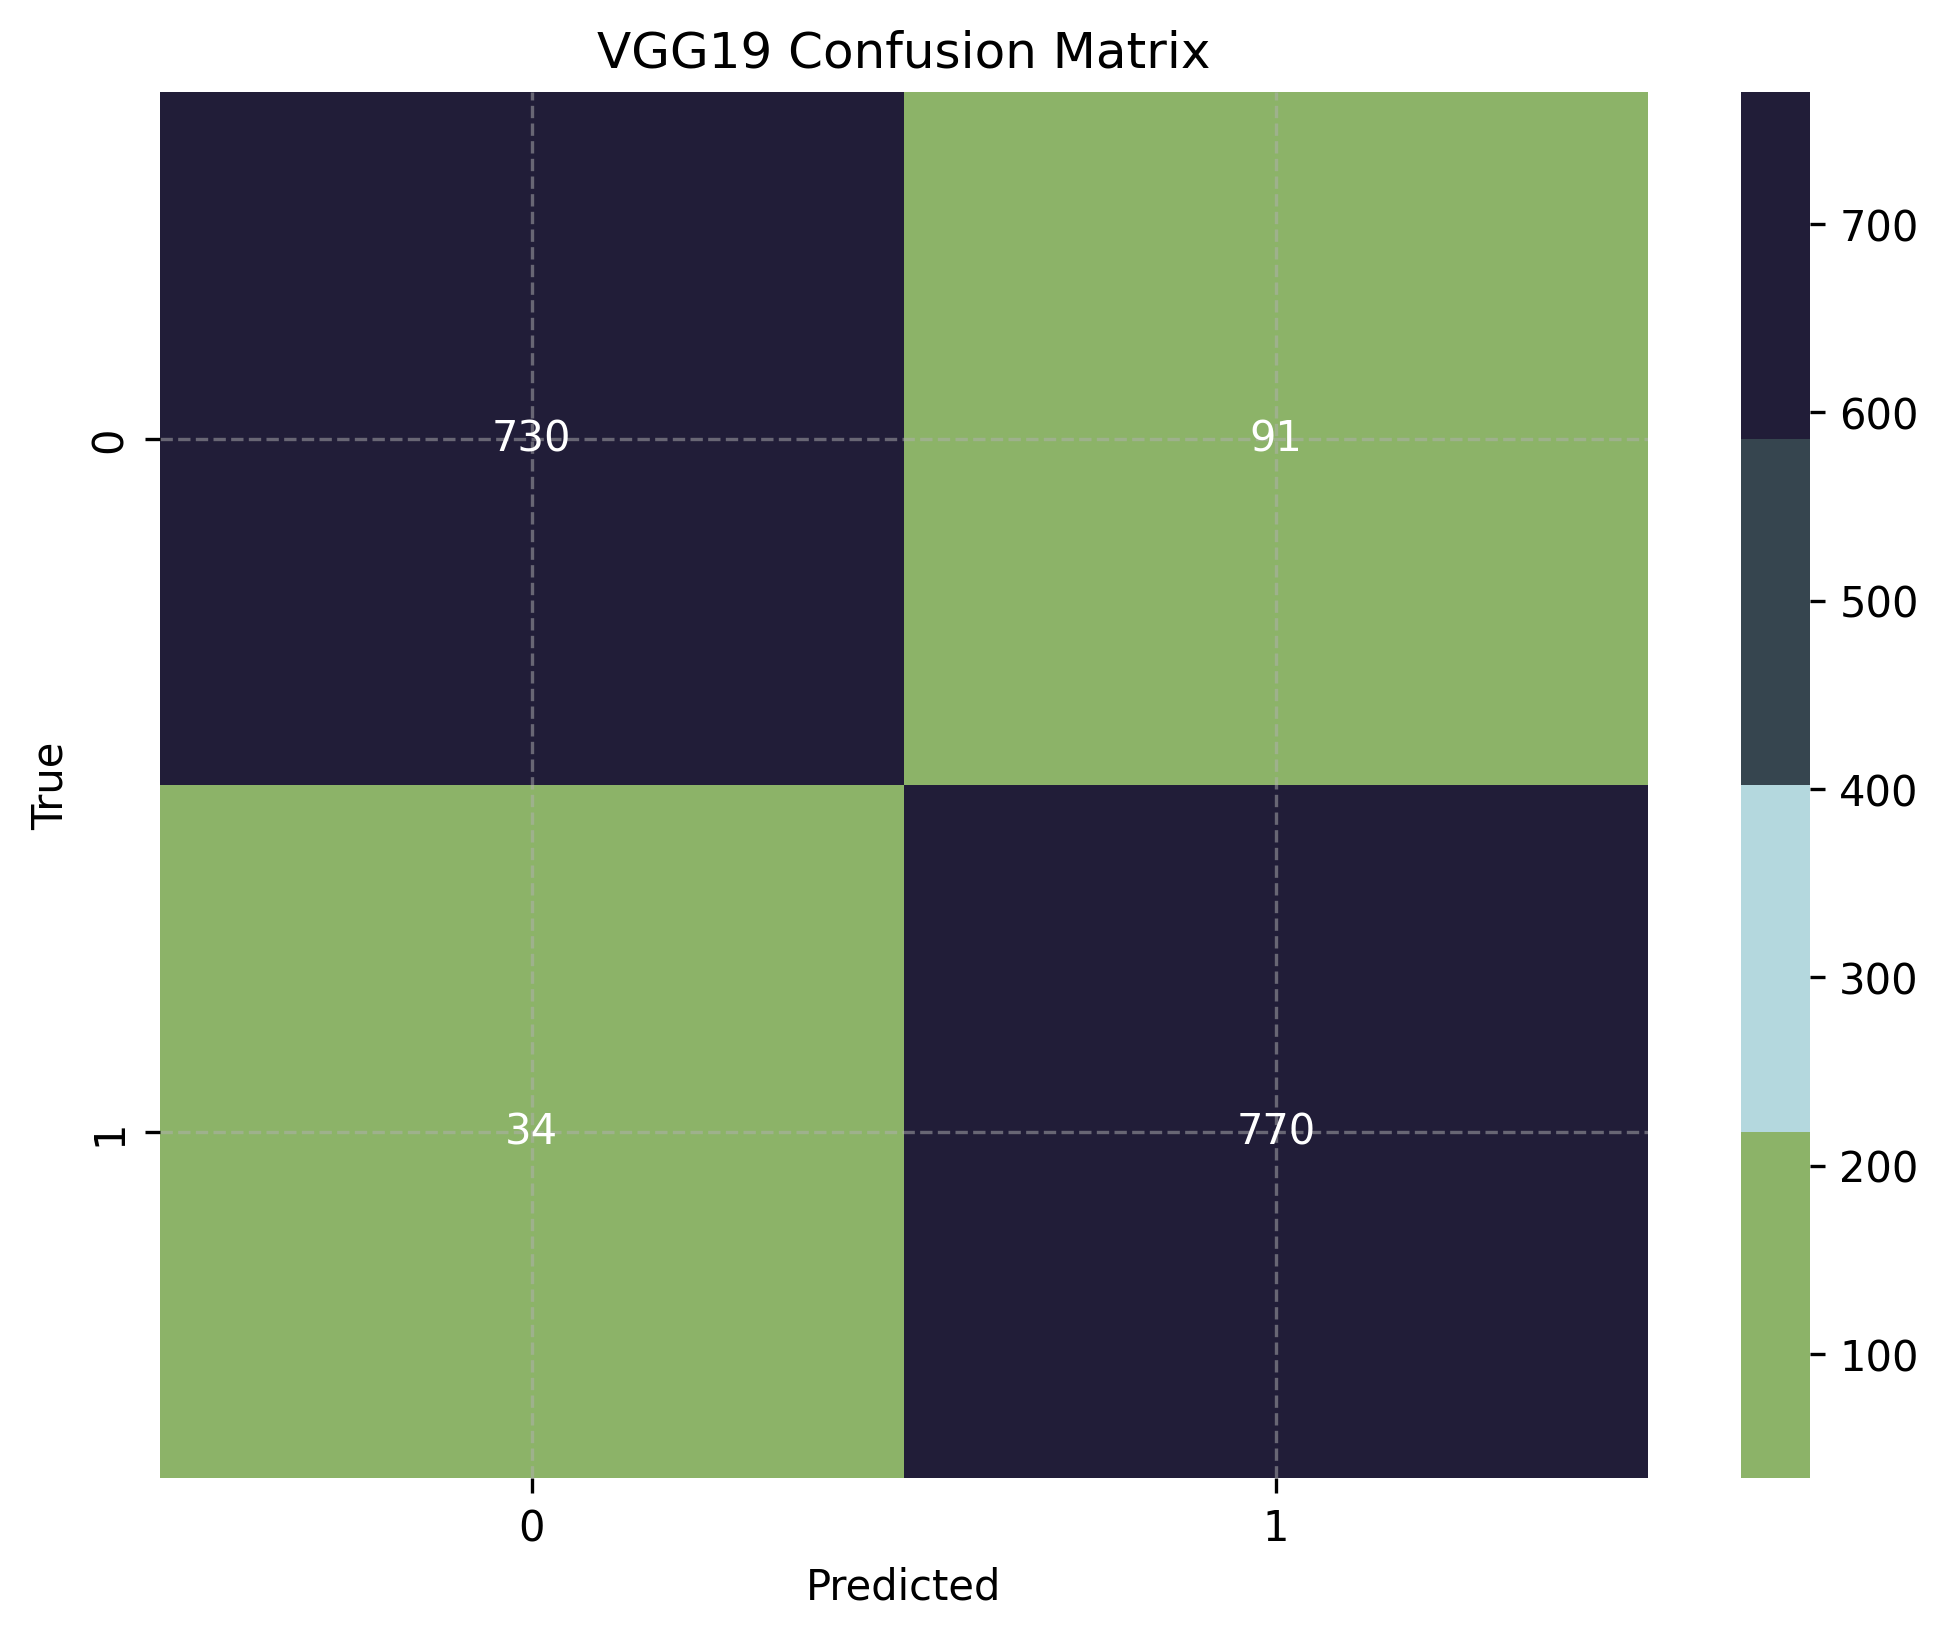

Confusion matrix saved for VGG19

==================== ResNet50V2 ====================
51/51 [==============================] - 8s 151ms/step
Misclassification Error: 0.0486

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       821
           1       0.95      0.95      0.95       804

    accuracy                           0.95      1625
   macro avg       0.95      0.95      0.95      1625
weighted avg       0.95      0.95      0.95      1625



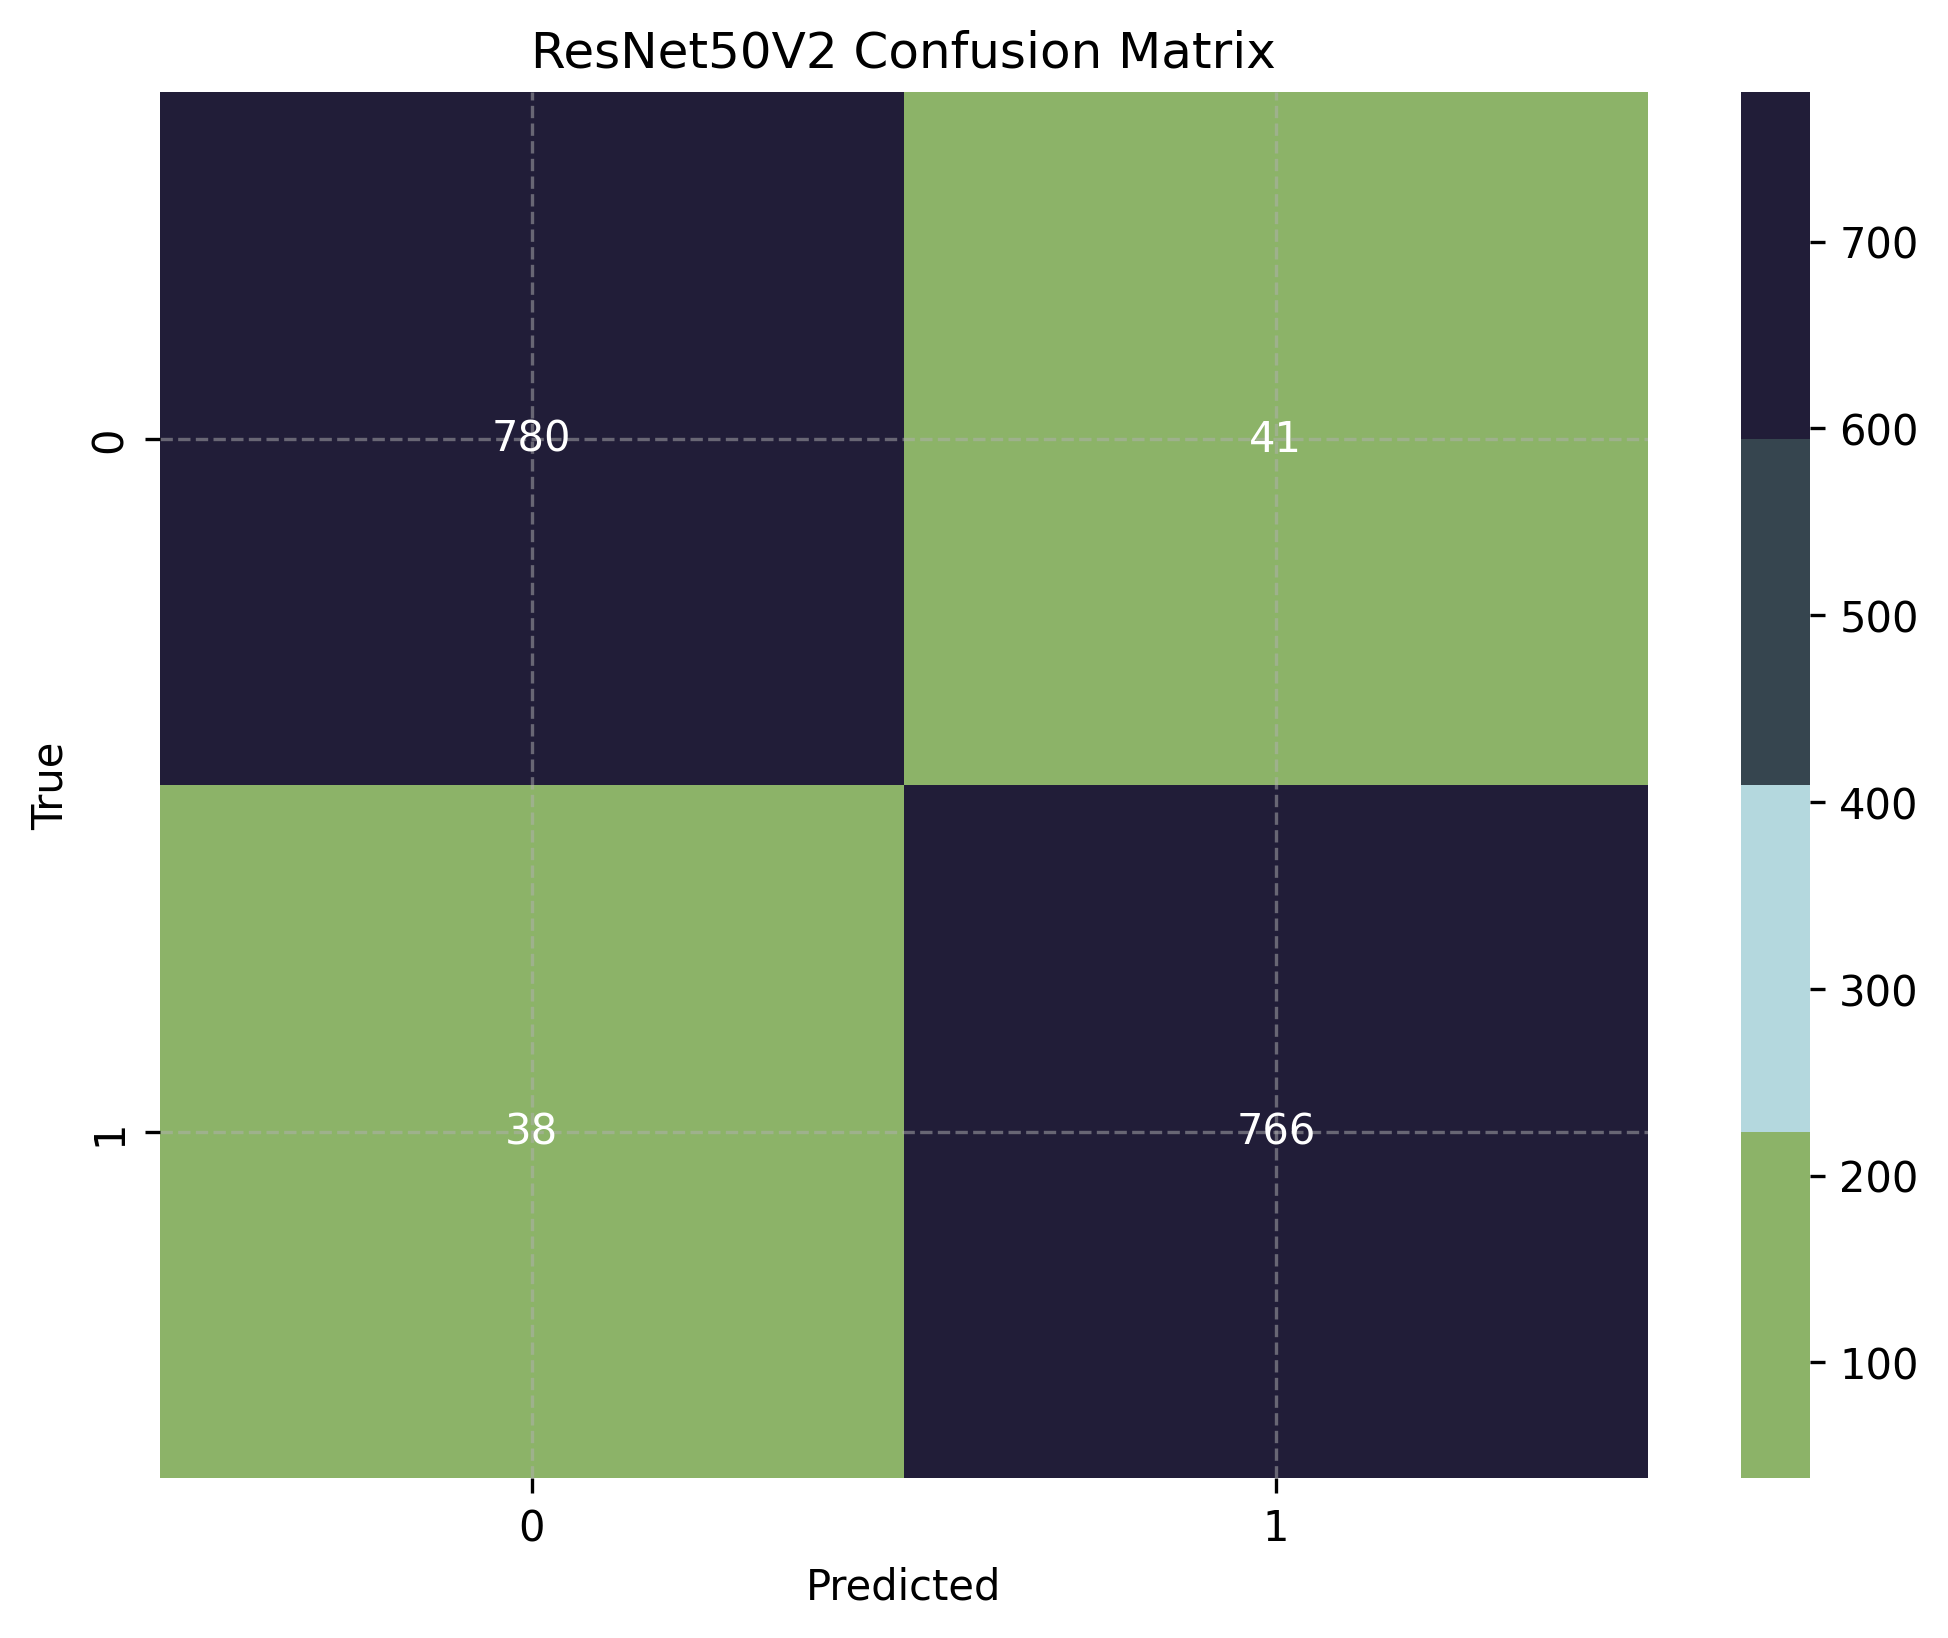

Confusion matrix saved for ResNet50V2

==================== DenseNet201 ====================
51/51 [==============================] - 9s 179ms/step
Misclassification Error: 0.0178

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       821
           1       0.97      0.99      0.98       804

    accuracy                           0.98      1625
   macro avg       0.98      0.98      0.98      1625
weighted avg       0.98      0.98      0.98      1625



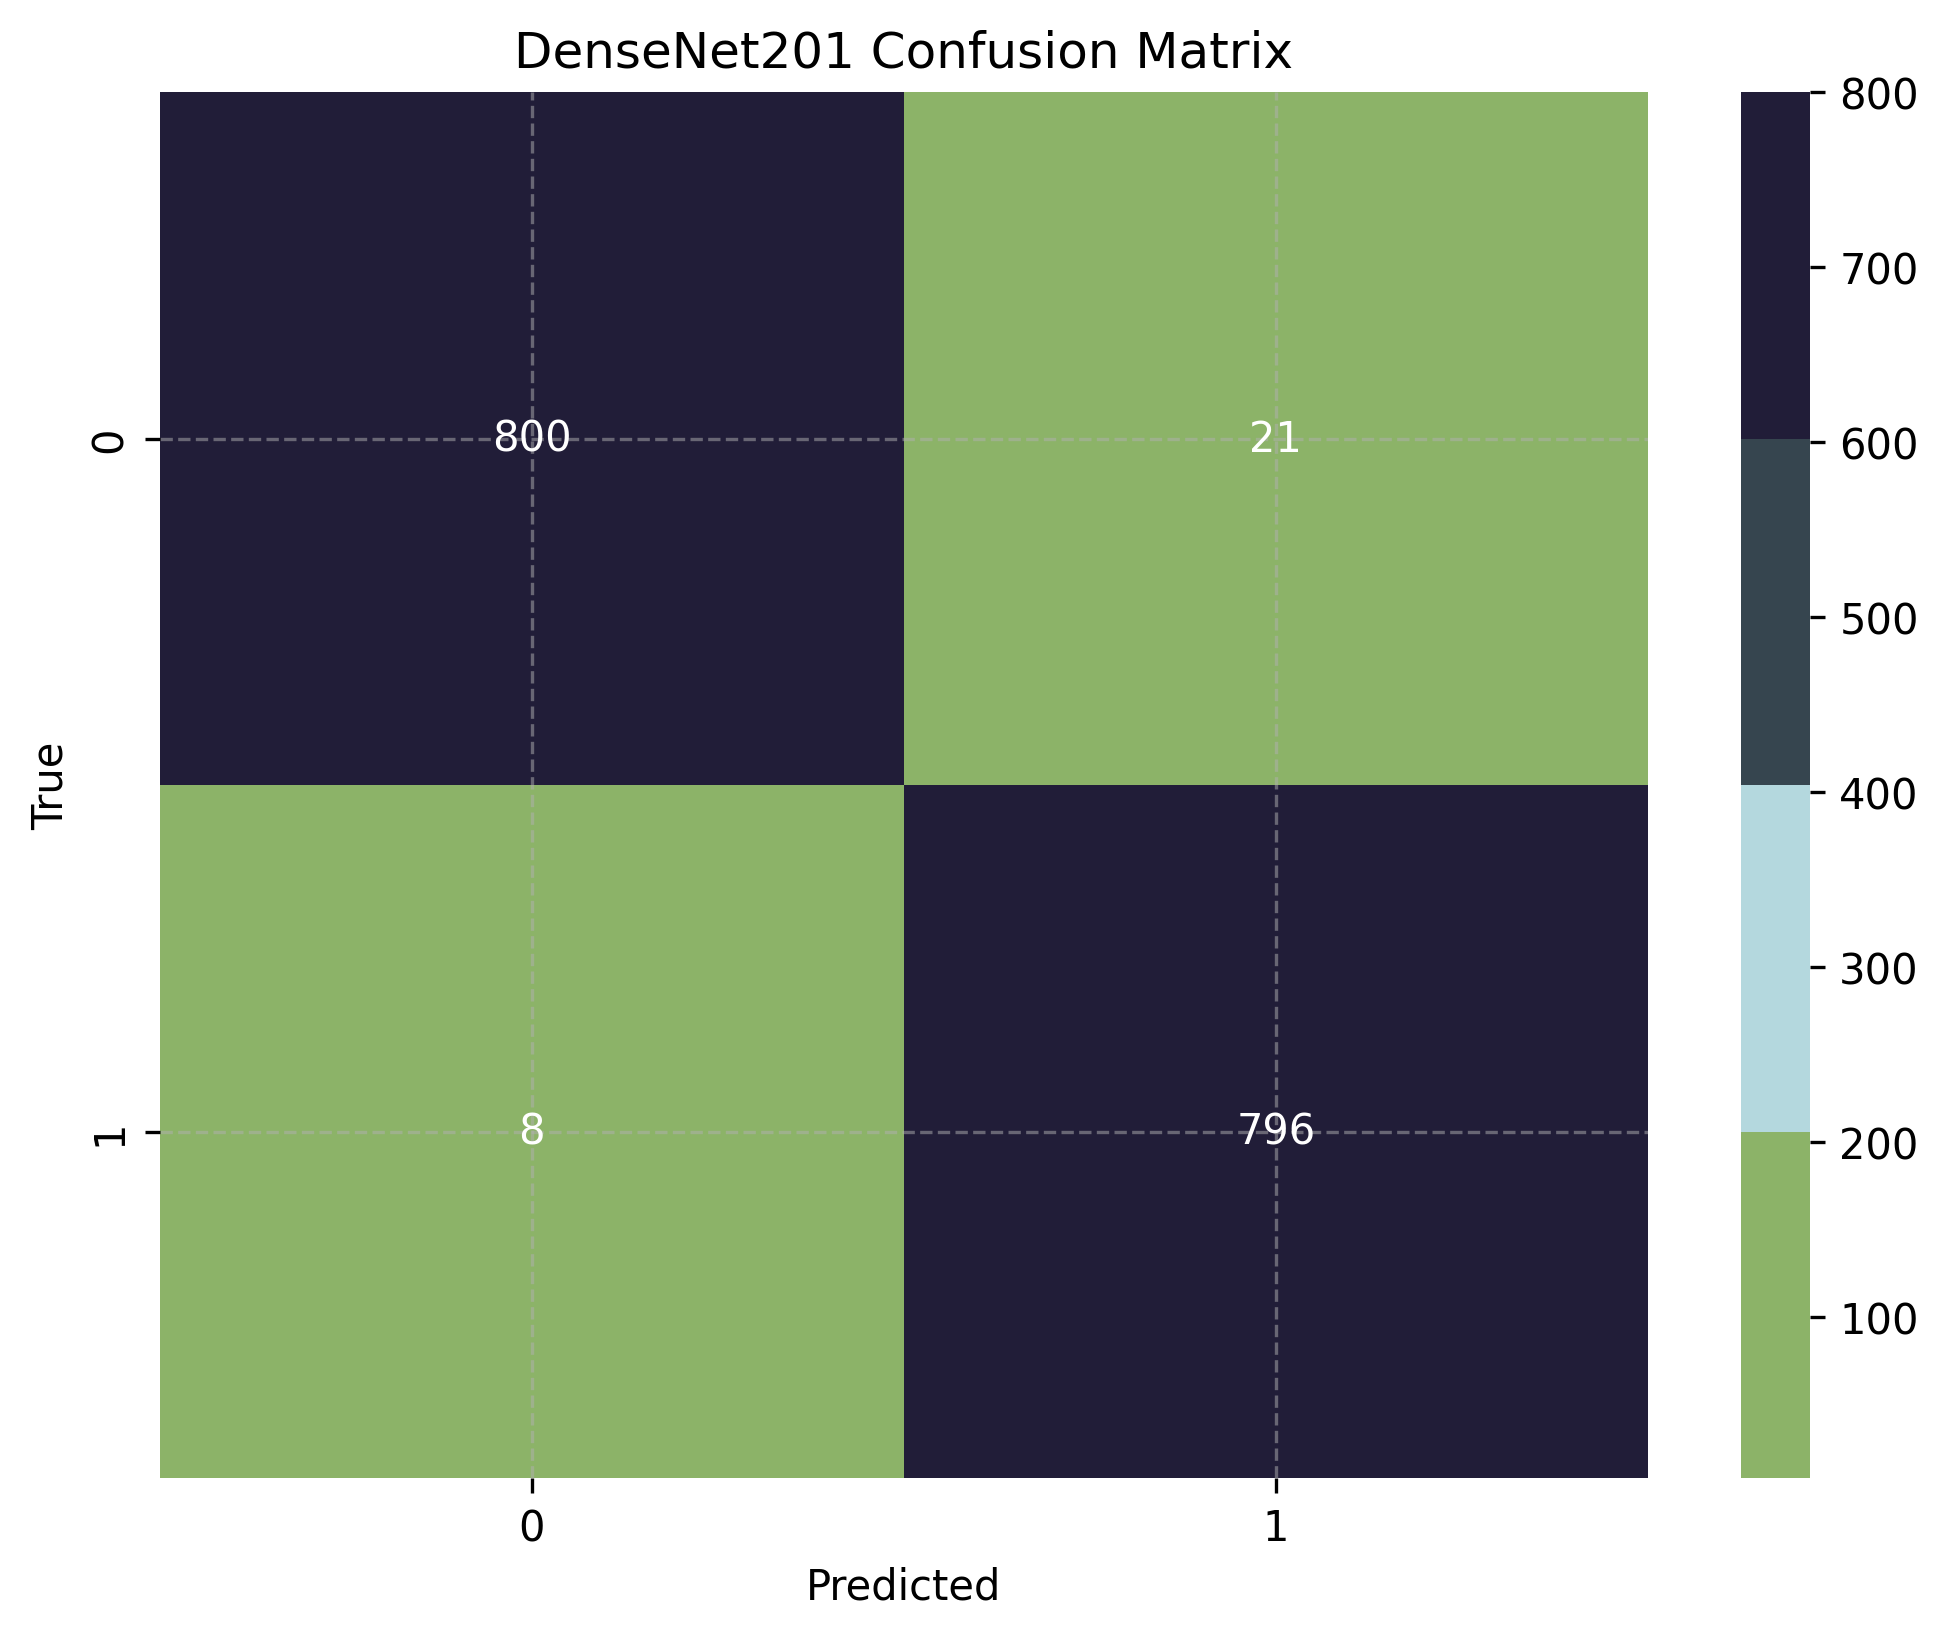

Confusion matrix saved for DenseNet201


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Custom color palette
custom_palette = ['#8CB368', '#B4D8DE', '#36454f', '#211d38']

# Output directory
output_dir = "/content/drive/MyDrive/Research Paper/Lyme Disease/AllOutput"
os.makedirs(output_dir, exist_ok=True)

# Fit the models
for name, model_info in models.items():
    # Get the model
    m = model_info['model']

    print(f"\n{ '=' * 20 } { name } {'=' * 20 }")

    # Reset the state of the test_images generator
    test_images.reset()

    # Get predictions on the test set
    y_pred = m.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get true labels
    y_true = test_images.classes

    # Calculate misclassification error
    misclassification_error = 1 - accuracy_score(y_true, y_pred_classes)

    print(f'Misclassification Error: {misclassification_error:.4f}')

    # Display classification report
    print('\nClassification Report:\n', classification_report(y_true, y_pred_classes))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6), dpi=300)
    sns.heatmap(cm, annot=True, fmt='g', cmap=sns.color_palette(custom_palette, as_cmap=True),
                xticklabels=sorted(set(y_true)), yticklabels=sorted(set(y_true)))
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Saving the plot
    confusion_matrix_plot = os.path.join(output_dir, f"{name}_Confusion_Matrix.png")
    plt.savefig(confusion_matrix_plot, bbox_inches='tight')
    plt.show()

    print(f"Confusion matrix saved for {name}")

## Transfer Leraning model class_probabilities Single Image


In [ ]:
import os

# Assuming you have a dictionary named models
models = {
    'model1': '/content/drive/MyDrive/Research Paper/Final_Model/DenseNet201',
    'model2': '/content/drive/MyDrive/Research Paper/Final_Model/ResNet50V2',
    'model3': '/content/drive/MyDrive/Research Paper/Final_Model/VGG19'
}

loaded_models = {}

for name, path in models.items():
    loaded_model = tf.keras.models.load_model(path)
    loaded_models[name] = loaded_model



In [ ]:
# Define a function for image classification
def classify_image(model, image_path, class_names):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0  # Rescale the image to match the training data preprocessing

    # Make predictions
    predictions = model.predict(img)

    # Get the class label with the highest probability
    predicted_class = np.argmax(predictions)

    # Get the class name
    class_name = class_names[predicted_class]

    return class_name, predictions[0]


In [ ]:
from tensorflow.keras.preprocessing import image
# Load the saved models
model_DenseNet201 = tf.keras.models.load_model("/content/drive/MyDrive/Research Paper/Final_Model/DenseNet201")
model_ResNet50V2 = tf.keras.models.load_model("/content/drive/MyDrive/Research Paper/Final_Model/ResNet50V2")
model_VGG19 = tf.keras.models.load_model("/content/drive/MyDrive/Research Paper/Final_Model/VGG19")

image_path = '/content/drive/MyDrive/Research Paper/Lyme Disease/Final Data/positive/contrast_EM rash153.jpg'

# Define your class names
class_names = ["negative", "positive"]

# Perform classification for DenseNet201
class_name_DenseNet201, probabilities_DenseNet201 = classify_image(model_DenseNet201, image_path, class_names)

# Perform classification for ResNet50V2
class_name_ResNet50V2, probabilities_ResNet50V2 = classify_image(model_ResNet50V2, image_path, class_names)

# Perform classification for VGG19
class_name_VGG19, probabilities_VGG19 = classify_image(model_VGG19, image_path, class_names)

1/1 [==============================] - 2s 2s/step


DenseNet201 Prediction:
Predicted Class: positive
Class Probabilities:
negative: 0.0000
positive: 1.0000


ResNet50V2 Prediction:
Predicted Class: positive
Class Probabilities:
negative: 0.0000
positive: 1.0000


VGG19 Prediction:
Predicted Class: positive
Class Probabilities:
negative: 0.0035
positive: 0.9965




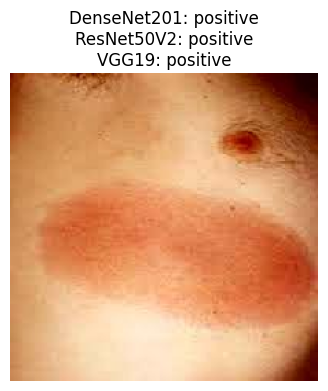

In [ ]:
# Print the results for DenseNet201
print("DenseNet201 Prediction:")
print(f"Predicted Class: {class_name_DenseNet201}")
print("Class Probabilities:")
for i, prob in enumerate(probabilities_DenseNet201):
    print(f"{class_names[i]}: {prob:.4f}")
print("\n")

# Print the results for ResNet50V2
print("ResNet50V2 Prediction:")
print(f"Predicted Class: {class_name_ResNet50V2}")
print("Class Probabilities:")
for i, prob in enumerate(probabilities_ResNet50V2):
    print(f"{class_names[i]}: {prob:.4f}")
print("\n")

# Print the results for VGG19
print("VGG19 Prediction:")
print(f"Predicted Class: {class_name_VGG19}")
print("Class Probabilities:")
for i, prob in enumerate(probabilities_VGG19):
    print(f"{class_names[i]}: {prob:.4f}")
print("\n")

# Plot the image with predicted class names
plt.figure(figsize=(4, 4))
plt.imshow(image.load_img(image_path, target_size=(224, 224)))
plt.axis('off')
plt.title(f"DenseNet201: {class_name_DenseNet201}\nResNet50V2: {class_name_ResNet50V2}\nVGG19: {class_name_VGG19}")
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
# Load the saved models
model_DenseNet201 = tf.keras.models.load_model("/content/drive/MyDrive/Research Paper/Final_Model/DenseNet201")
model_ResNet50V2 = tf.keras.models.load_model("/content/drive/MyDrive/Research Paper/Final_Model/ResNet50V2")
model_VGG19 = tf.keras.models.load_model("/content/drive/MyDrive/Research Paper/Final_Model/VGG19")

image_path = '/content/drive/MyDrive/Research Paper/Lyme Disease/Final Data/negative/Bacterial cellulitis109.jpg'

# Define your class names
class_names = ["negative", "positive"]

# Perform classification for DenseNet201
class_name_DenseNet201, probabilities_DenseNet201 = classify_image(model_DenseNet201, image_path, class_names)

# Perform classification for ResNet50V2
class_name_ResNet50V2, probabilities_ResNet50V2 = classify_image(model_ResNet50V2, image_path, class_names)

# Perform classification for VGG19
class_name_VGG19, probabilities_VGG19 = classify_image(model_VGG19, image_path, class_names)

1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 0s 179ms/step


DenseNet201 Prediction:
Predicted Class: negative
Class Probabilities:
negative: 1.0000
positive: 0.0000


ResNet50V2 Prediction:
Predicted Class: negative
Class Probabilities:
negative: 1.0000
positive: 0.0000


VGG19 Prediction:
Predicted Class: negative
Class Probabilities:
negative: 1.0000
positive: 0.0000




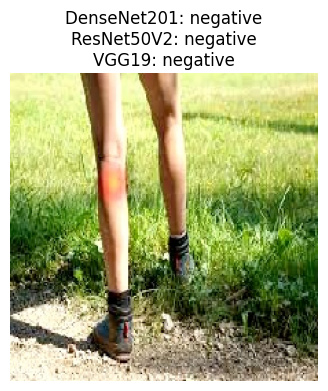

In [ ]:
# Print the results for DenseNet201
print("DenseNet201 Prediction:")
print(f"Predicted Class: {class_name_DenseNet201}")
print("Class Probabilities:")
for i, prob in enumerate(probabilities_DenseNet201):
    print(f"{class_names[i]}: {prob:.4f}")
print("\n")

# Print the results for ResNet50V2
print("ResNet50V2 Prediction:")
print(f"Predicted Class: {class_name_ResNet50V2}")
print("Class Probabilities:")
for i, prob in enumerate(probabilities_ResNet50V2):
    print(f"{class_names[i]}: {prob:.4f}")
print("\n")

# Print the results for VGG19
print("VGG19 Prediction:")
print(f"Predicted Class: {class_name_VGG19}")
print("Class Probabilities:")
for i, prob in enumerate(probabilities_VGG19):
    print(f"{class_names[i]}: {prob:.4f}")
print("\n")


# Plot the image with predicted class names
plt.figure(figsize=(4, 4))
plt.imshow(image.load_img(image_path, target_size=(224, 224)))
plt.axis('off')
plt.title(f"DenseNet201: {class_name_DenseNet201}\nResNet50V2: {class_name_ResNet50V2}\nVGG19: {class_name_VGG19}")
plt.show()

## Hybrid Model DensNet201 and VGG19

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet201, VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define the input shape
input_shape = (224, 224, 3)

# Enable mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Define the input layer
input_layer = Input(shape=input_shape, name='input_layer')

# Load pre-trained models
densenet_model = DenseNet201(weights='imagenet', include_top=False, input_tensor=input_layer)
vgg19_model = VGG19(weights='imagenet', include_top=False, input_tensor=input_layer)

# Global average pooling layer for each model
densenet_gap = GlobalAveragePooling2D()(densenet_model.output)
vgg19_gap = GlobalAveragePooling2D()(vgg19_model.output)

# Concatenate the outputs from both models
concatenated_features = Concatenate()([densenet_gap, vgg19_gap])

# Adding Batch Normalization before the Dense layer
concatenated_features_bn = BatchNormalization()(concatenated_features)

# Additional dense layers for further processing with L2 regularization and Dropout
dense_layer1 = Dense(512, kernel_regularizer=l2(0.001))(concatenated_features_bn)  # Consider tuning the L2 regularization rate
dense_layer1_bn = BatchNormalization()(dense_layer1)
dense_layer1_act = Activation('relu')(dense_layer1_bn)
dense_layer1_dropout = Dropout(0.5)(dense_layer1_act)  # Consider tuning the Dropout rate

dense_layer2 = Dense(256, kernel_regularizer=l2(0.001))(dense_layer1_dropout)  # L2 regularization
dense_layer2_bn = BatchNormalization()(dense_layer2)
dense_layer2_act = Activation('relu')(dense_layer2_bn)
dense_layer2_dropout = Dropout(0.5)(dense_layer2_act)  # Dropout

# Output layer for binary classification
output_layer = Dense(2, activation='softmax', dtype='float32')(dense_layer2_dropout)  # Ensuring dtype='float32' for the output with mixed precision

# Create the hybrid model
hybrid_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model using the Adam optimizer with a tunable learning rate
optimizer = Adam(learning_rate=0.00001)  # Consider tuning the learning rate

hybrid_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
# hybrid_model.summary()


## Model Fit


In [ ]:
# Fit the model
history = hybrid_model.fit(train_images, validation_data=val_images, epochs=20, verbose=1)

Epoch 1/20
204/204 [==============================] - 4838s 23s/step - loss: 1.9586 - accuracy: 0.6557 - val_loss: 1.5118 - val_accuracy: 0.8449
Epoch 2/20
204/204 [==============================] - 168s 822ms/step - loss: 1.4928 - accuracy: 0.8496 - val_loss: 1.2992 - val_accuracy: 0.9467
Epoch 3/20
204/204 [==============================] - 168s 824ms/step - loss: 1.3477 - accuracy: 0.9066 - val_loss: 1.2072 - val_accuracy: 0.9617
Epoch 4/20
204/204 [==============================] - 162s 794ms/step - loss: 1.2432 - accuracy: 0.9404 - val_loss: 1.1378 - val_accuracy: 0.9828
Epoch 5/20
204/204 [==============================] - 168s 825ms/step - loss: 1.1840 - accuracy: 0.9509 - val_loss: 1.1110 - val_accuracy: 0.9763
Epoch 6/20
204/204 [==============================] - 158s 774ms/step - loss: 1.1291 - accuracy: 0.9660 - val_loss: 1.0425 - val_accuracy: 0.9960
Epoch 7/20
204/204 [==============================] - 159s 777ms/step - loss: 1.0768 - accuracy: 0.9789 - val_loss: 1.0149 - 

## Save Model

In [ ]:
# Specify the path where you want to save the model
hybrid_model.save('/content/drive/MyDrive/Research Paper/Lyme Disease/AllOutput/Model/Skin-VisualNet')

## Result Analysis

<Figure size 640x480 with 0 Axes>

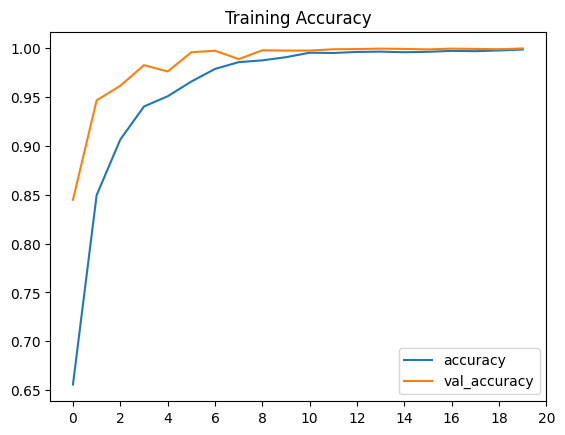

<Figure size 640x480 with 0 Axes>

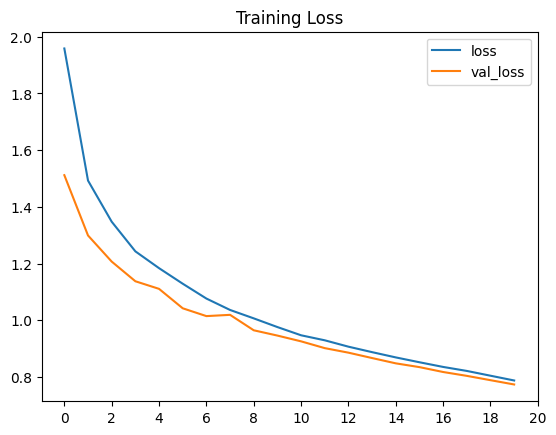



Accuracy on the test set: 98.83%
51/51 [==============================] - 13s 165ms/step
Accuracy: 0.98831
Precision: 0.98833
Recall: 0.98831
F1 Score: 0.98831
              precision    recall  f1-score   support

    negative       0.99      0.99      0.99       858
    positive       0.98      0.99      0.99       767

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625

Confusion Matrix of Skin-VisualNet: 




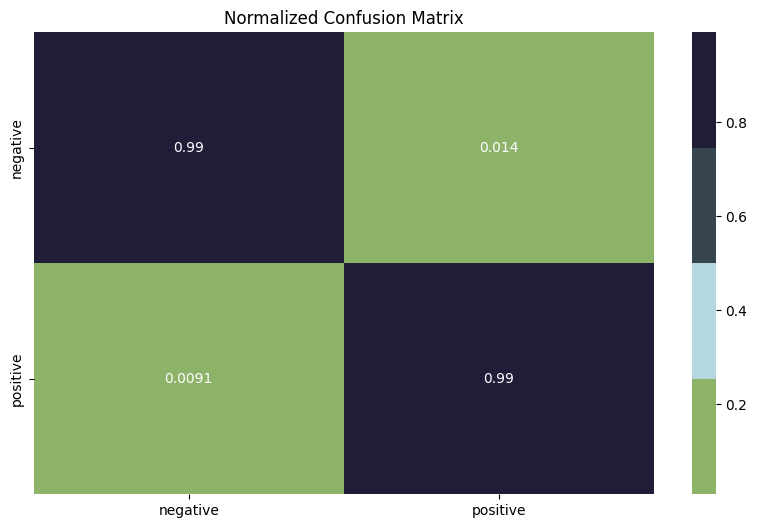

Performance: 

Recall: 98.84437596302003
Specificity: 99.99928840884422
Precision: 98.84552945993335
False Positive Rate: 0.0007115911557758461
False Negative Rate: 1.1556240369799686
Negative Predictive Value: 99.99928840929194
False Discovery Rate: 1.1544705400666584


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from statistics import mean

# Directory to save the figures
output_dir = '/content/drive/MyDrive/Research Paper/Lyme Disease/AllOutput'  # Update this to your desired path
os.makedirs(output_dir, exist_ok=True)
print('\n')

# Assuming history, hybrid_model, test_images, and train_images are defined
# ...

val_acc = history.history['val_accuracy']
train_acc = history.history['accuracy']
results = hybrid_model.evaluate(test_images, verbose=0)
res = results[1]
test_acc = [round(res, 4)]

# Plotting training accuracy and loss
plt.figure()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Training Accuracy")
plt.xticks(range(0, 21, 2))  # Set x-axis ticks to specific values
plt.savefig(os.path.join(output_dir, 'training_accuracy_plot.png'))  # Save the figure
plt.show()

plt.figure()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Training Loss")
plt.xticks(range(0, 21, 2))  # Set x-axis ticks to specific values
plt.savefig(os.path.join(output_dir, 'training_loss_plot.png'))  # Save the figure
plt.show()

# Display accuracy on the test set
print("\n\nAccuracy on the test set: {:.2f}%".format(results[1] * 100))


# Evaluate model performance
pred = hybrid_model.predict(test_images)
pred = np.argmax(pred, axis=1)

# Map the label
labels = (train_images.class_indices)  # Assuming this is defined earlier in your code
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]
y_test = list(test_df.Label)  # Assuming test_df is defined earlier in your code

print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred), 5))
print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'), 5))
print('Recall:', np.round(metrics.recall_score(y_test, pred, average='weighted'), 5))
print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'), 5))
print(classification_report(y_test, pred))

# Plot the normalized confusion matrix with custom color palette
print("Confusion Matrix of Skin-VisualNet: \n\n")
cf_matrix = confusion_matrix(y_test, pred, normalize='true')

# Define your custom palette
custom_palette = ['#8CB368', '#B4D8DE', '#36454f', '#211d38']  # Custom color palette

plt.figure(figsize=(10, 6))
sns.heatmap(cf_matrix, annot=True, cmap=sns.color_palette(custom_palette), xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.savefig(os.path.join(output_dir, 'normalized_confusion_matrix.png'))  # Save the figure
plt.show()
confusion_matrix=cf_matrix
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = len(y_test) - (FP + FN + TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Print and save the performance metrics
performance_metrics = {
    "Recall": mean(TPR)*100,
    "Specificity": mean(TNR)*100,
    "Precision": mean(PPV)*100,
    "False Positive Rate": mean(FPR)*100,
    "False Negative Rate": mean(FNR)*100,
    "Negative Predictive Value": mean(NPV)*100,
    "False Discovery Rate": mean(FDR)*100
}
print("Performance: \n")
for metric, value in performance_metrics.items():
    print(f"{metric}: {value}")

# Save performance metrics to a text file
with open(os.path.join(output_dir, 'performance_metrics.txt'), 'w') as f:
    for metric, value in performance_metrics.items():
        f.write(f"{metric}: {value}\n")

## Class Probability

1/1 [==============================] - 3s 3s/step
Predicted Class: negative
Class Probabilities:
negative: 0.9980
positive: 0.0019


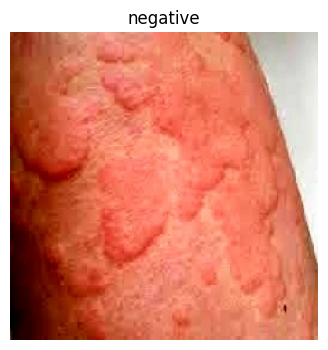

In [ ]:
import keras.utils as image
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = load_model("/content/drive/MyDrive/Research Paper/Final_Model/GeoNet201_Fusion")

# Define class names
class_names = ["negative", "positive"]

# Define image path
image_path = '/content/drive/MyDrive/Research Paper/Lyme Disease/Final Data/negative/Urticartia232.jpg'


# Load and preprocess the image
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img / 255.0

# Make predictions
predictions = model.predict(img)

# Get the class label with the highest probability
predicted_class = np.argmax(predictions)

# Get the class name
class_name = class_names[predicted_class]

# Print the results
print(f"Predicted Class: {class_name}")
print("Class Probabilities:")
for i, prob in enumerate(predictions[0]):
    print(f"{class_names[i]}: {prob:.4f}")

# Plot the image with the predicted class name
plt.figure(figsize=(4, 4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()


1/1 [==============================] - 4s 4s/step
Predicted Class: positive
Class Probabilities:
negative: 0.0000
positive: 1.0000


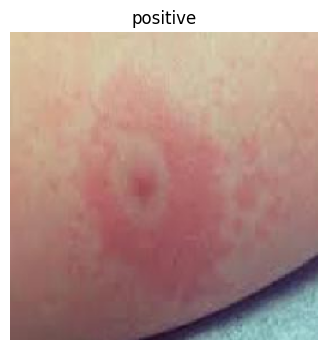

In [ ]:
import keras.utils as image
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = load_model("/content/drive/MyDrive/Research Paper/Final_Model/GeoNet201_Fusion")

# Define class names
class_names = ["negative", "positive"]

# Define image path
image_path = '/content/drive/MyDrive/Research Paper/Lyme Disease/Final Data/positive/zoom_EM rash24.jpg'


# Load and preprocess the image
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img / 255.0

# Make predictions
predictions = model.predict(img)

# Get the class label with the highest probability
predicted_class = np.argmax(predictions)

# Get the class name
class_name = class_names[predicted_class]

# Print the results
print(f"Predicted Class: {class_name}")
print("Class Probabilities:")
for i, prob in enumerate(predictions[0]):
    print(f"{class_names[i]}: {prob:.4f}")

# Plot the image with the predicted class name
plt.figure(figsize=(4, 4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()


## Roc Curve

Unique classes in y_test: ['negative' 'positive']
51/51 [==============================] - 13s 164ms/step


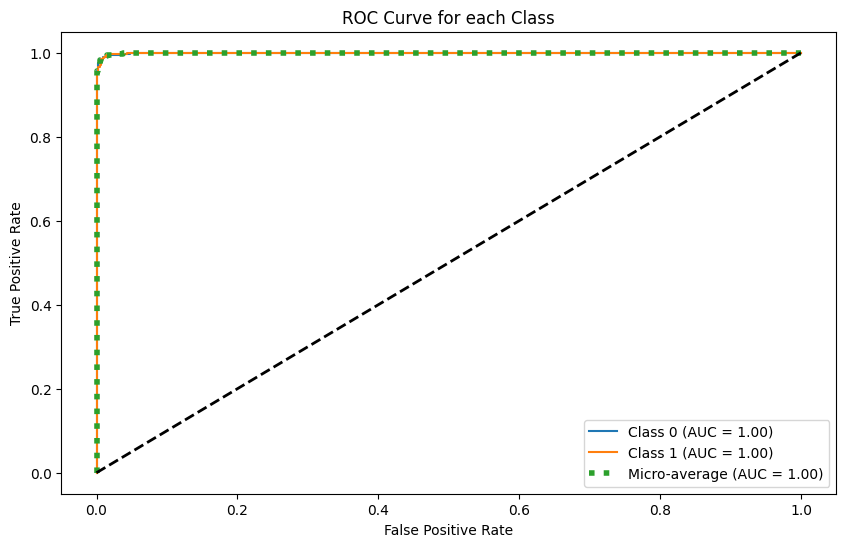

ROC curve plot saved at: /content/drive/MyDrive/Research Paper/Lyme Disease/AllOutput/roc_curve_geoNet201_fusion.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model

# Assuming 'hybrid_model' is your trained model, 'test_images' is your test dataset
# and 'y_test' contains the true labels for your test set

# Directory to save the ROC curve plot
output_dir = '/content/drive/MyDrive/Research Paper/Lyme Disease/AllOutput'
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist

# Load the saved model
hybrid_model = load_model('/content/drive/MyDrive/Research Paper/Lyme Disease/AllOutput/Model/Skin-VisualNet')

# Check the unique classes in y_test
unique_classes = np.unique(y_test)  # Ensure y_test is defined
print("Unique classes in y_test:", unique_classes)

# Ensure that there are 2 unique classes
if len(unique_classes) != 2:
    raise ValueError(f"Expected 2 unique classes in y_test, got {len(unique_classes)}")

# Convert labels to binary matrix
y_test_bin = label_binarize(y_test, classes=unique_classes)

# Handling a special case for binary classification
if y_test_bin.shape[1] == 1:
    # Add a second column for the negative class
    y_test_bin = np.hstack((1 - y_test_bin, y_test_bin))

# Predict probabilities for each class
y_score = hybrid_model.predict(test_images)  # Ensure test_images is defined

# Ensure that y_score has two columns (for two classes)
if y_score.shape[1] != 2:
    raise ValueError(f"y_score should have 2 columns for 2 classes, found {y_score.shape[1]}")

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(2):  # Binary classification, hence range(2)
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(2):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
         linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each Class')
plt.legend(loc='lower right')

# Save the ROC curve plot
roc_curve_path = os.path.join(output_dir, 'roc_curve_geoNet201_fusion.png')
plt.savefig(roc_curve_path, bbox_inches='tight')
plt.show()

# Inform the user
print(f"ROC curve plot saved at: {roc_curve_path}")


## MIsclasification Error


==================== Model: Skin-VisualNet ====================
51/51 [==============================] - 15s 165ms/step
Misclassification Error: 0.0117

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       858
           1       0.98      0.99      0.99       767

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



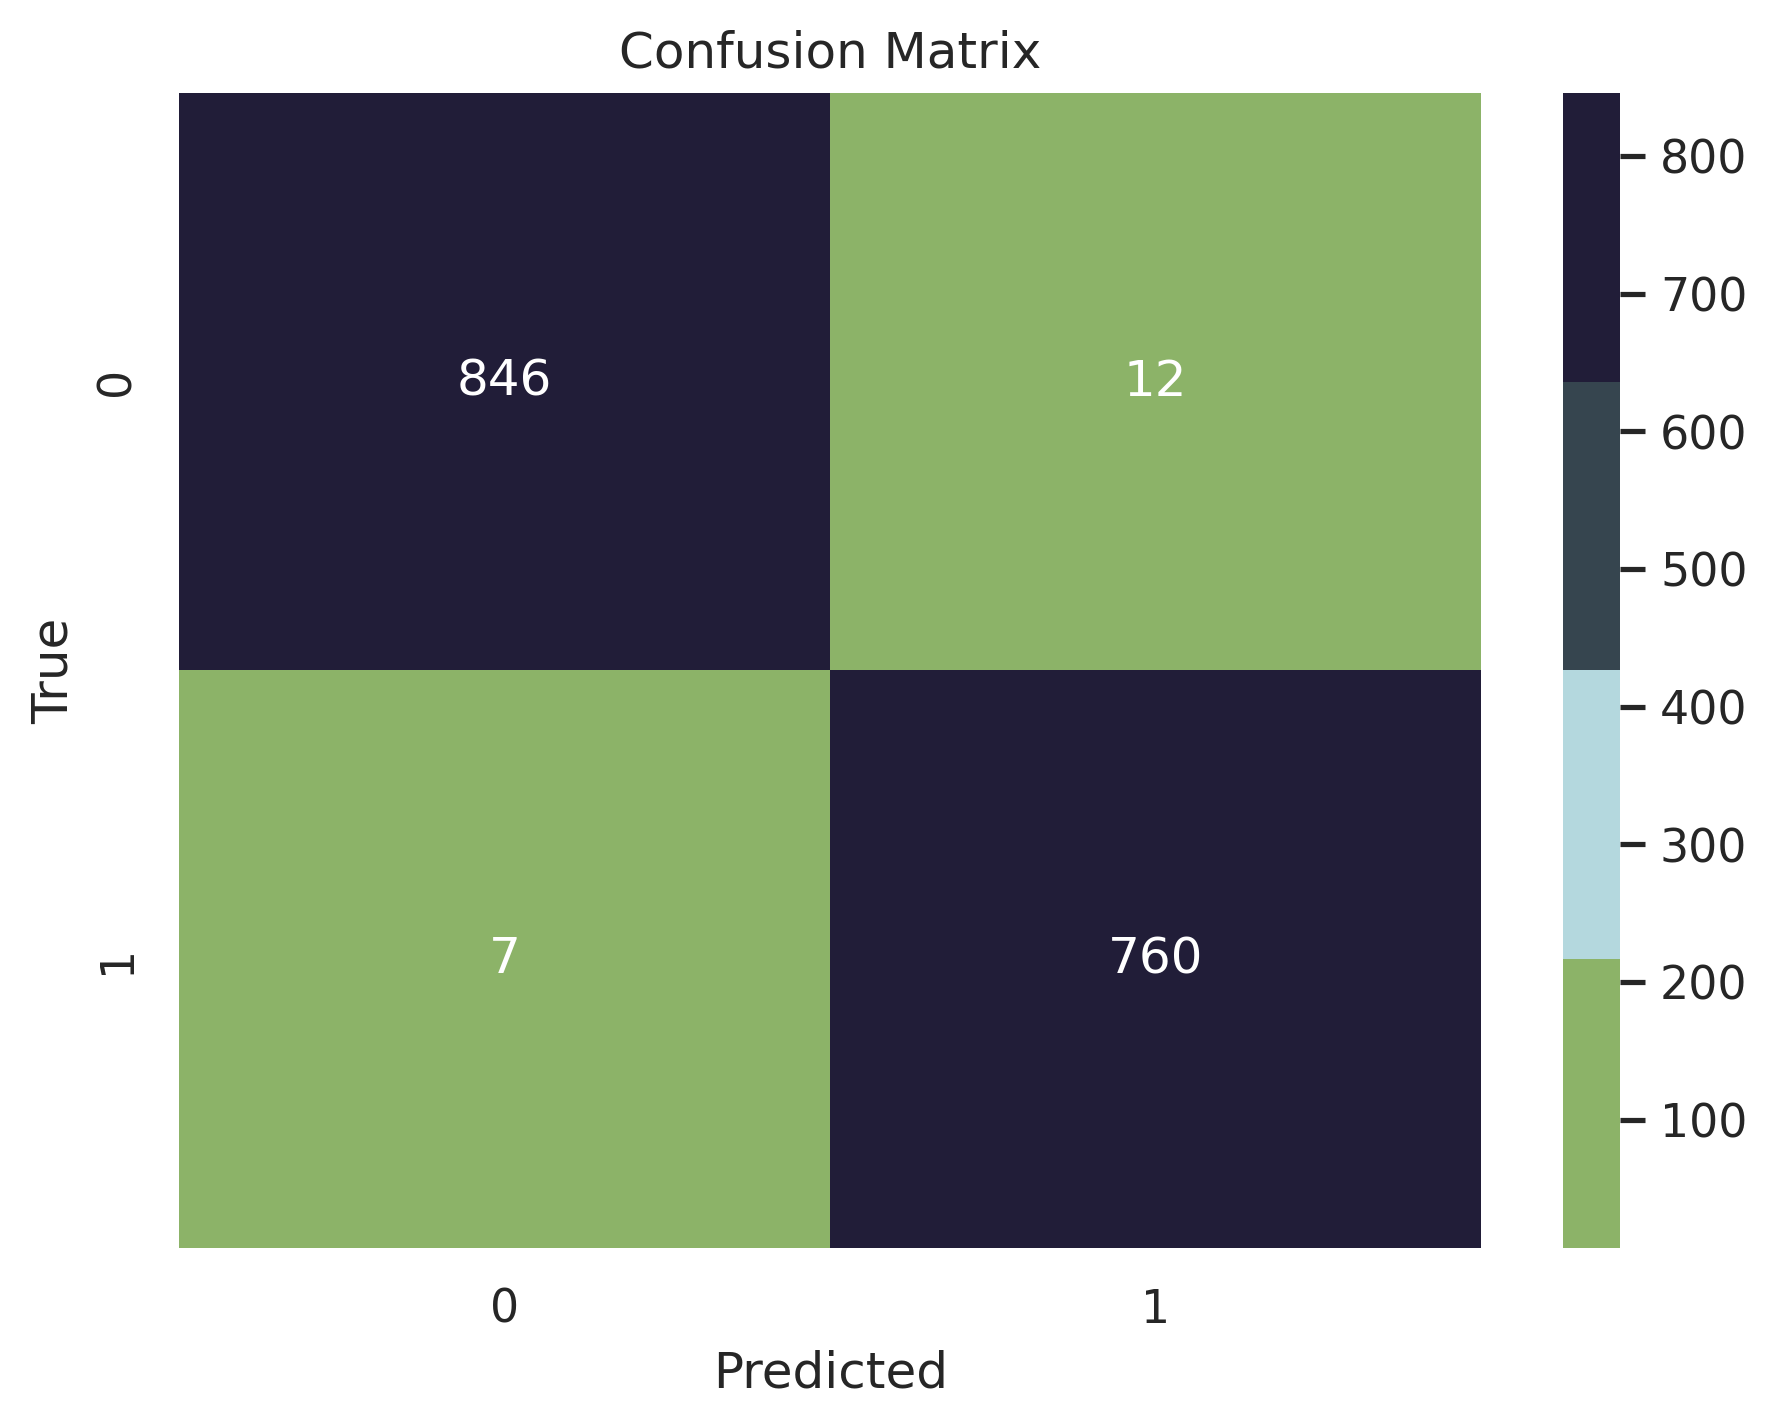

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os

# Load the saved model
model_path = '/content/drive/MyDrive/Research Paper/Lyme Disease/AllOutput/Model/Skin-VisualNet'
m = tf.keras.models.load_model(model_path)

# Directory to save the figures and reports
output_dir = '/content/drive/MyDrive/Research Paper/Lyme Disease/AllOutput'
os.makedirs(output_dir, exist_ok=True)

# Apply a consistent and appealing style
sns.set(style="whitegrid")

# Define custom color palette
cmap = sns.color_palette(['#8CB368', '#B4D8DE', '#36454f', '#211d38'])

print(f"\n{ '=' * 20 } Model: {model_path.split('/')[-1]} {'=' * 20 }")

# Assuming test_images is defined and reset
test_images.reset()

# Predictions
y_pred = m.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_images.classes

# Misclassification error
misclassification_error = 1 - accuracy_score(y_true, y_pred_classes)
print(f'Misclassification Error: {misclassification_error:.4f}')

# Classification report
report = classification_report(y_true, y_pred_classes)
print('\nClassification Report:\n', report)

# Save classification report
with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
    f.write(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(7, 5), dpi=300)
sns.heatmap(cm, annot=True, fmt='g', cmap=cmap,
            xticklabels=sorted(set(y_true)), yticklabels=sorted(set(y_true)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Save the confusion matrix plot
cm_plot_path = os.path.join(output_dir, 'confusion_matrix_Skin-VisualNet_fusion.png')
plt.savefig(cm_plot_path, bbox_inches='tight')
plt.show()


## Accuracy Bar

<ipython-input-16-de08ec1d44e6>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.barplot(x='Deep Learning Model', y='Accuracy', data=df, palette=colors)


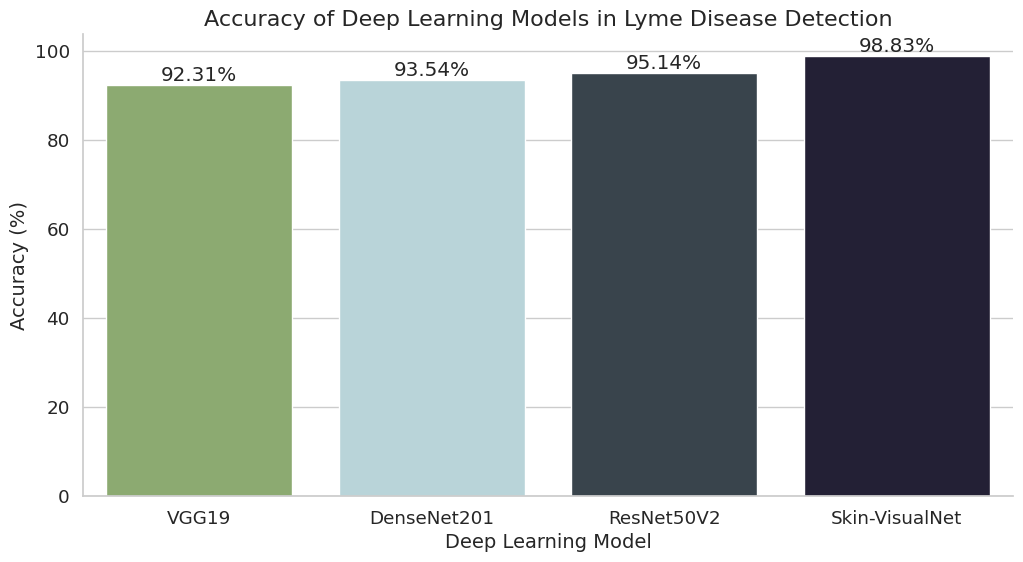

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# New color palette
colors = ['#8CB368', '#B4D8DE', '#36454f', '#211d38']

# DataFrame with your data
df = pd.DataFrame(data={
    'Deep Learning Model': ['VGG19', 'DenseNet201', 'ResNet50V2', 'Skin-VisualNet'],
    'Accuracy': [92.31, 93.54, 95.14, 98.83]
})

# Set the overall aesthetics
sns.set(style="whitegrid", palette=colors, font_scale=1.2)

plt.figure(figsize=(12, 6))

# Create the bar plot
p = sns.barplot(x='Deep Learning Model', y='Accuracy', data=df, palette=colors)

# Add labels to each bar
for i in p.containers:
    labels = [f'{v.get_height():0.02f}%' for v in i]
    p.bar_label(i, labels=labels)

# Enhance the plot with titles and labels
plt.title('Accuracy of Deep Learning Models in Lyme Disease Detection', fontsize=16)
plt.xlabel('Deep Learning Model', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)

# Optional: Remove the top and right spines for a cleaner look
sns.despine()

# Save the plot to your specified directory
output_path = '/content/drive/MyDrive/Research Paper/Lyme Disease/AllOutput/accuracy_plot_aesthetic.png'
plt.savefig(output_path, bbox_inches='tight')

# Display the plot
plt.show()


## F1,Recall,Precission,Accuracy Bar

<ipython-input-22-f92474c16430>:41: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  p = sns.barplot(x='Metric', y='Score', hue='Model', data=df_melted, palette=palette)


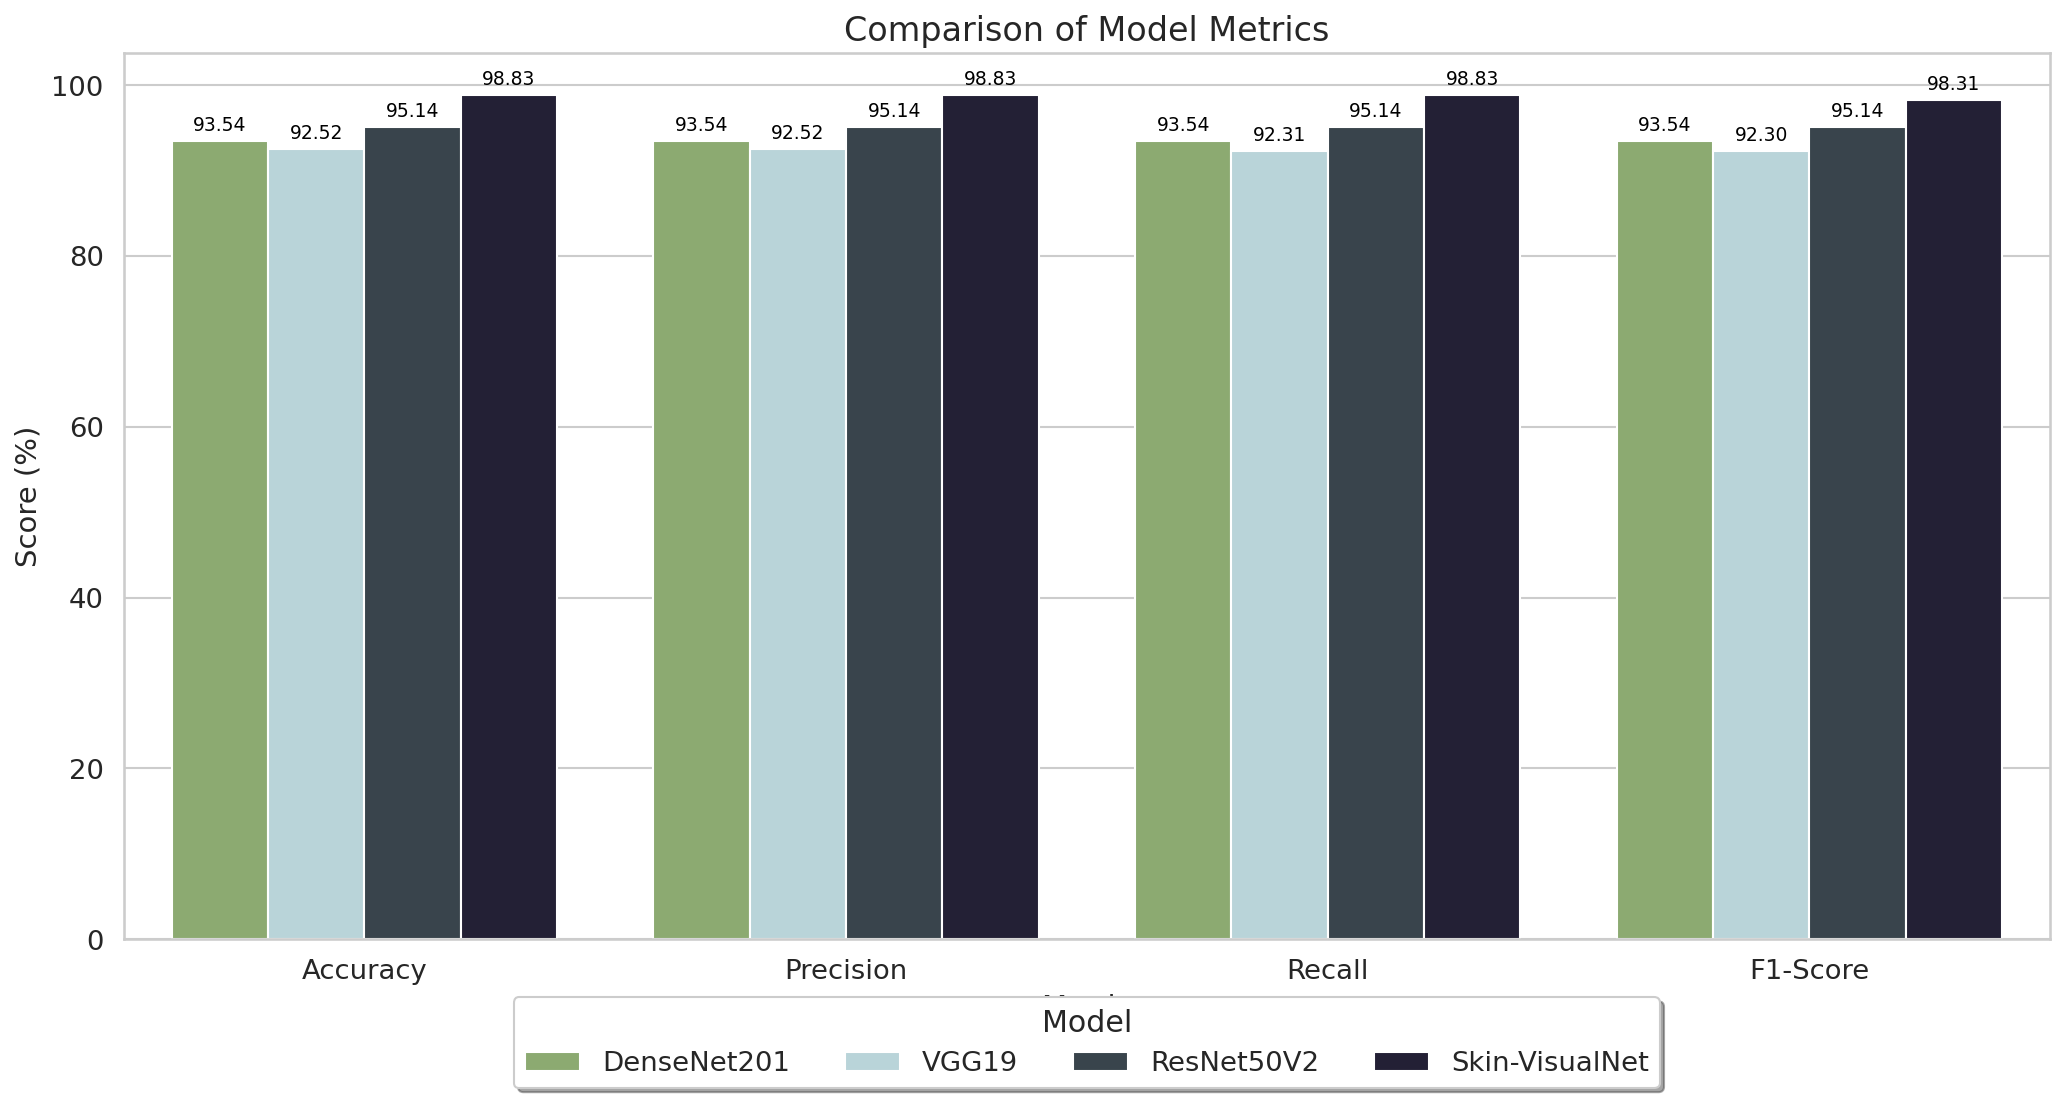

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Model results
results = {
    'DenseNet201': {'Accuracy': 93.54, 'Precision': 93.54, 'Recall': 93.54, 'F1-Score': 93.54},
    'VGG19': {'Accuracy': 92.52, 'Precision': 92.52, 'Recall': 92.31, 'F1-Score': 92.30},
    'ResNet50V2': {'Accuracy': 95.14, 'Precision': 95.14, 'Recall': 95.14, 'F1-Score': 95.14},
    'Skin-VisualNet': {'Accuracy': 98.83, 'Precision': 98.83, 'Recall': 98.83, 'F1-Score': 98.31}
}

# Model to color mapping
model_colors = {
    'DenseNet201': '#8CB368',
    'VGG19': '#B4D8DE',
    'ResNet50V2': '#36454f',
    'Skin-VisualNet': '#211d38'
}

# Convert results to DataFrame
df_results = pd.DataFrame(results).T  # Transpose to get models as rows
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Model'}, inplace=True)

# Melt the DataFrame for seaborn
df_melted = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Set the overall aesthetics
sns.set(style="whitegrid", font_scale=1.2)

# Increase the figure's DPI for better resolution
plt.figure(figsize=(14, 8), dpi=150)

# Create a custom palette based on model_colors mapping
palette = df_melted['Model'].map(model_colors).unique()

# Create the bar plot using the custom palette
p = sns.barplot(x='Metric', y='Score', hue='Model', data=df_melted, palette=palette)

# Loop over the bars in each container to put the text on them
for container in p.containers:
    p.bar_label(container, fmt='%.2f', label_type='edge', padding=3, fontsize=9, color='black')

# Enhance the plot with titles and labels
plt.title('Comparison of Model Metrics', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Score (%)', fontsize=14)

# Place the legend at the top of the plot
plt.legend(title='Model', loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to make space for the legend at the top

# Save the plot
output_dir = '/content/drive/MyDrive/Research Paper/Lyme Disease/FinalOutput/Other'  # Update this to your environment's output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, 'combined_metrics_plot_high_res.png')
plt.savefig(output_path, bbox_inches='tight')

plt.show()


## SSiM PSNR MSE RMSE
SSIM (Structural Similarity Index), PSNR (Peak Signal-to-Noise Ratio), MSE (Mean Squared Error), and RMSE (Root Mean Squared Error)

In [ ]:
import numpy as np
import pandas as pd
from skimage import io
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error
from skimage.transform import resize
import math
# Paths to your images
reference_images = [
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Data Set/Selected Positive/EM rash1.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Data Set/Selected Positive/EM rash37.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Data Set/Selected Positive/Erythema Migrans159.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Data Set/Selected Positive/bullseye rash127.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Data Set/Selected Positive/bullseye rash98.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Data Set/Positive/EM rash130.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Data Set/Selected Positive/Erythema Migrans190.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Data Set/Selected Positive/Erythema Migrans211.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Data Set/Selected Positive/bullseye rash168.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Data Set/Gamma_Corrected_Images/val/negative/Bacterial cellulitis131.jpg'
]  # 10 paths

test_images = [
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Final Data/positive/contrast_EM rash1.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Final Data/positive/gamma_EM rash37.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Final Data/positive/contrast_Erythema Migrans159.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Final Data/positive/gamma_bullseye rash127.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Final Data/positive/contrast_bullseye rash98.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Final Data/positive/rotated_45_EM rash130.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Final Data/positive/rotated_45_Erythema Migrans190.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Final Data/positive/zoom_Erythema Migrans211.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Final Data/positive/zoom_bullseye rash168.jpg',
    '/content/drive/MyDrive/Research Paper/Lyme Disease/Final Data/negative/Bacterial cellulitis131.jpg'
]  # 10 paths

# Ensure that the length of reference_images and test_images are the same
assert len(reference_images) == len(test_images)

# List to store the results
results = []

# Loop over the pairs of images
for i, (ref_img_path, test_img_path) in enumerate(zip(reference_images, test_images), start=1):
# Load the images
    true_image = io.imread(ref_img_path) / 255.0
    test_image = io.imread(test_img_path) / 255.0

    # Resize the test image to match the reference image dimensions
    test_image = resize(test_image, true_image.shape[:2], anti_aliasing=True)

    # Convert to float
    true_image = true_image.astype(np.float32)
    test_image = test_image.astype(np.float32)

    # Compute the metrics
    ssim_index = ssim(true_image, test_image, multichannel=True)
    psnr_value = psnr(true_image, test_image)
    mse_value = mean_squared_error(true_image, test_image)
    rmse_value = math.sqrt(mse_value)

    # Append the results for this pair
    results.append({
        "Image": f"Image {i}",
        "SSIM": ssim_index,
        "PSNR": psnr_value,
        "MSE": mse_value,
        "RMSE": rmse_value
    })


# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the DataFrame as a table
print(results_df)


<ipython-input-26-43d834210c96>:56: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_index = ssim(true_image, test_image, multichannel=True)


      Image      SSIM       PSNR       MSE      RMSE
0   Image 1  0.846624  21.174823  0.007630  0.087349
1   Image 2  0.931588  17.612324  0.017329  0.131639
2   Image 3  0.950745  21.689516  0.006777  0.082324
3   Image 4  0.823486  20.381293  0.009159  0.095705
4   Image 5  0.959904  23.746098  0.004221  0.064967
5   Image 6  0.347401   6.098852  0.245536  0.495516
6   Image 7  0.405885   8.937969  0.127704  0.357356
7   Image 8  0.899446  19.873140  0.010296  0.101471
8   Image 9  0.759238  20.984519  0.007972  0.089284
9  Image 10  0.909006  19.714105  0.010680  0.103346
